In [1]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user , expiring 31 Aug 2023
Serial number: 401709320927
  Licensed to: Bruno Komel
               University of Pittsburgh

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.



. 
. clear

. 
. local units = 30

. local start = 1

. local end       = 60

. 
. local time = `end' - `start' + 1

. local obsv = `units' * `time'

. set obs `obsv'
Number of observations (_N) was 0, now 1,800.

. 
. egen id    = seq(), b(`time')  

. egen t     = seq(), f(`start') t(`end')         

. 
. sort  id t

. xtset id t

Panel variable: id (strongly balanced)
 Time variable: t, 1 to 60
         Delta: 1 unit

. 
. 
. set seed 20211222

. 
. gen Y                   = 0             // outcome variable     

. gen D                   = 0             // intervention variable

. gen cohort      = .     // treatment cohort
(1,800 missing values generated)

. gen effect      = .             // treatment effect size
(1,800 missing values generated)

. gen first_treat = .             // when the treatment happens for each cohort
(1,800 missing values generated)

. gen rel_time    = .     // time - first_treat
(1,800 missing values generated)

. 
. levelsof id, local(lvls) //randoml

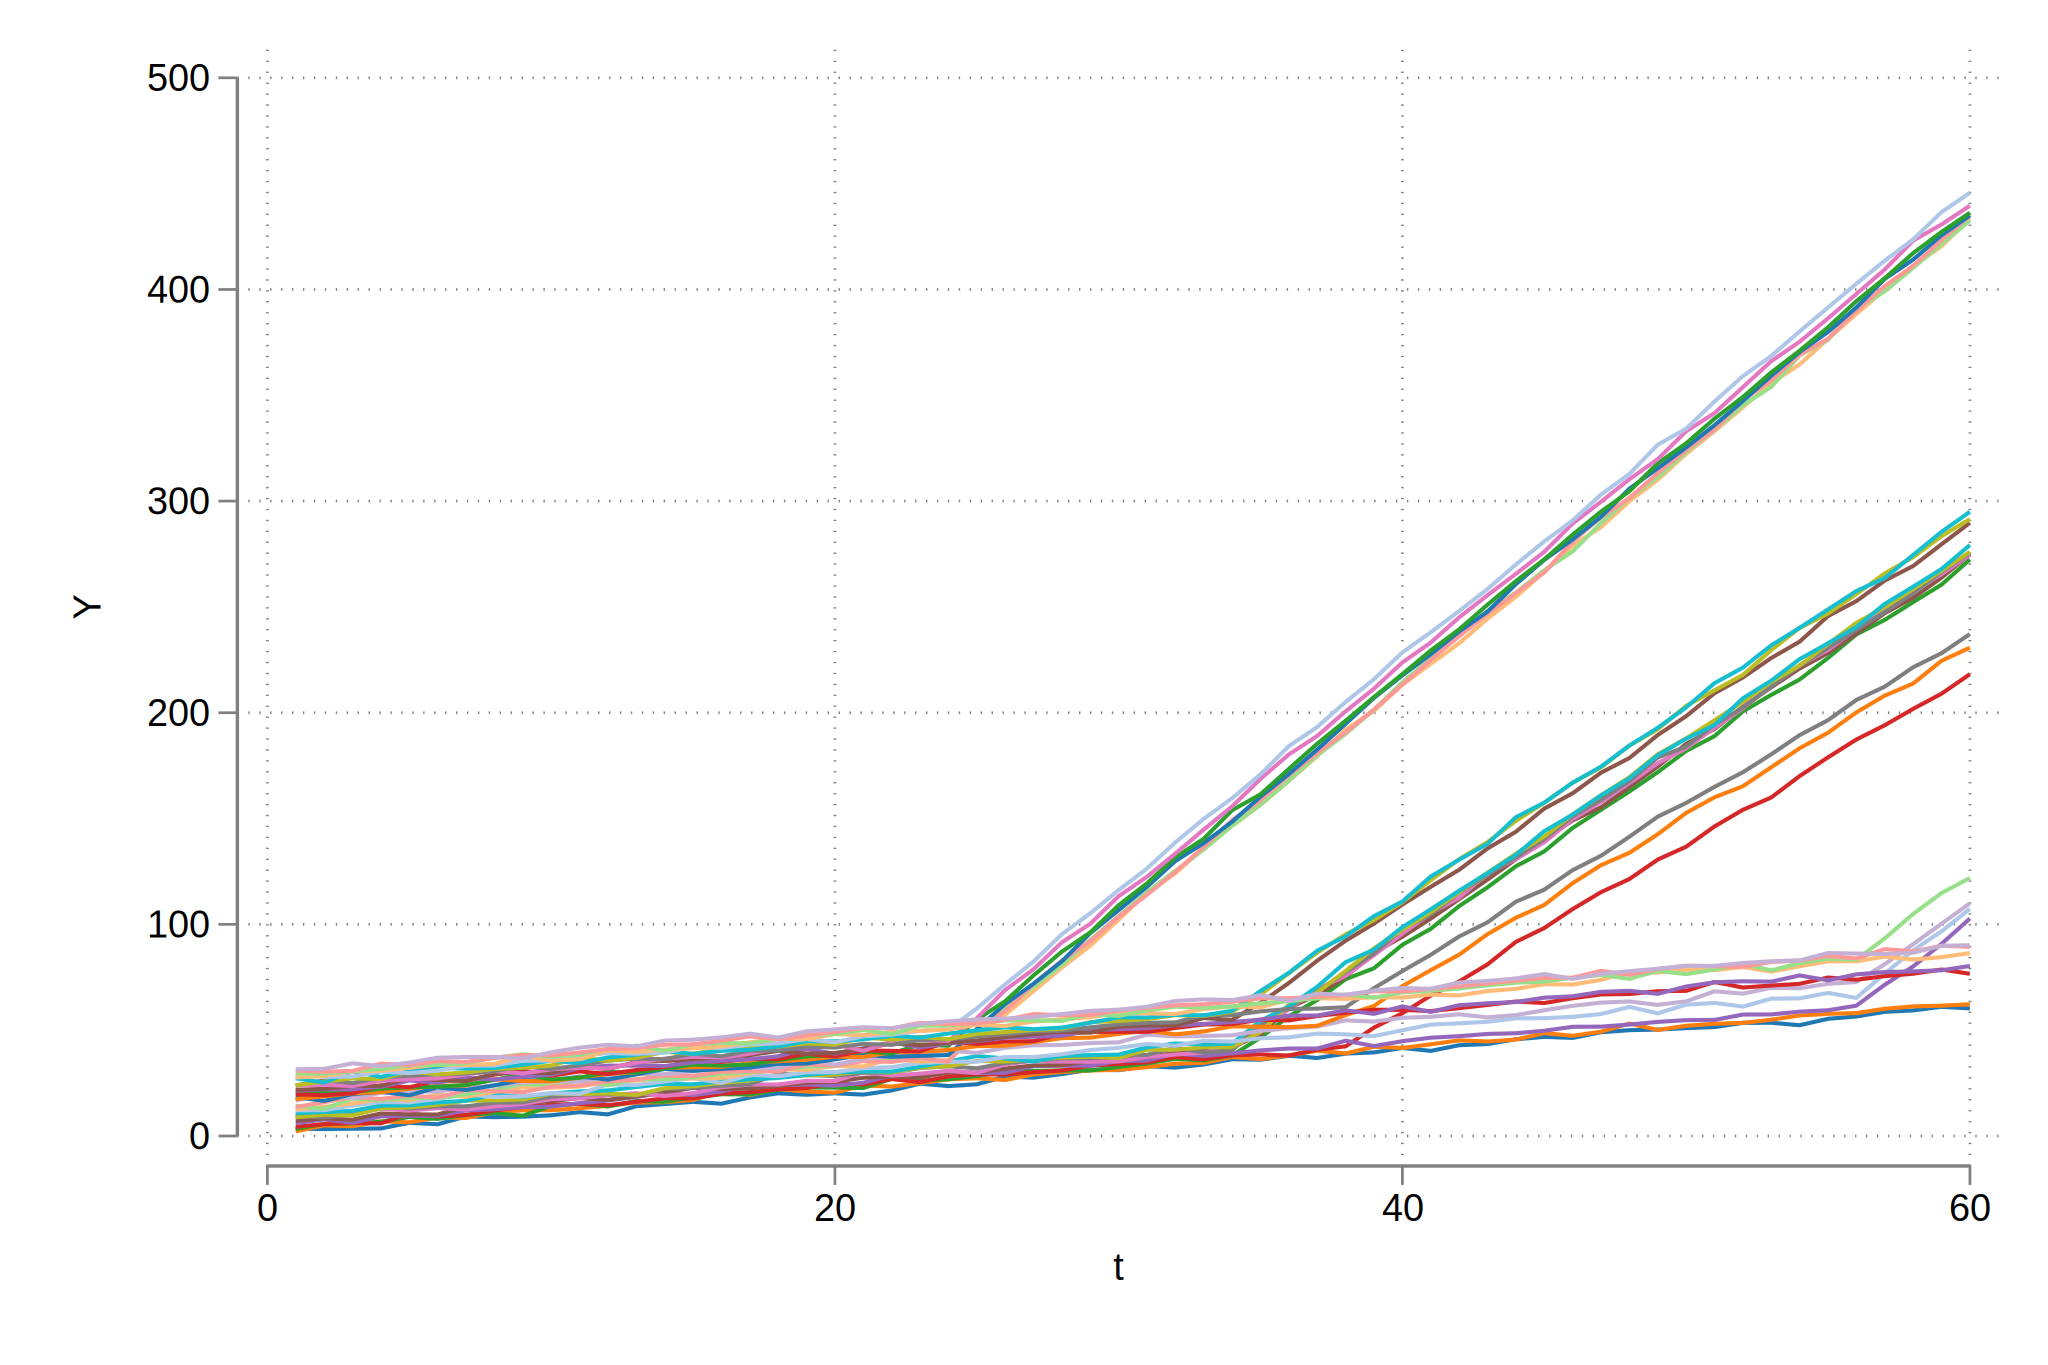

In [2]:
%%stata

clear

local units = 30
local start = 1
local end 	= 60

local time = `end' - `start' + 1
local obsv = `units' * `time'
set obs `obsv'

egen id	   = seq(), b(`time')  
egen t 	   = seq(), f(`start') t(`end') 	

sort  id t
xtset id t


set seed 20211222

gen Y 	   		= 0		// outcome variable	
gen D 	   		= 0		// intervention variable
gen cohort      = .  	// treatment cohort
gen effect      = .		// treatment effect size
gen first_treat = .		// when the treatment happens for each cohort
gen rel_time	= .     // time - first_treat

levelsof id, local(lvls) //randomly assigning observations into cohorts
foreach x of local lvls {
	local chrt = runiformint(0,5)	
	replace cohort = `chrt' if id==`x'
}

levelsof cohort , local(lvls)  
foreach x of local lvls {
	
	local eff = runiformint(2,10)
		replace effect = `eff' if cohort==`x'
			
	local timing = runiformint(`start',`end' + 20)	// 
	replace first_treat = `timing' if cohort==`x'
	replace first_treat = . if first_treat > `end'
		replace D = 1 if cohort==`x' & t>= `timing' 
}

replace rel_time = t - first_treat
replace Y = id + t + cond(D==1, effect * rel_time, 0) + rnormal()

xtline Y, overlay legend(off) // Here we can see the effects of staggered treatments

gen gvar = first_treat
recode gvar (. = 0)


# • csdid

In [3]:
%%stata

// ssc install reghdfe
// ssc install ftools

reghdfe Y D, abs(cohort t) 



. 
. reghdfe Y D, abs(cohort t) 
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =      1,800
Absorbing 2 HDFE groups                           F(   1,   1734) =     424.08
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.7936
                                                  Adj R-squared   =     0.7859
                                                  Within R-sq.    =     0.1965
                                                  Root MSE        =    43.3914

------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
           D |   77.59101   3.767778    20.59   0.000     70.20114    84.98088
       _cons |   63.63619   1.605114    39.65   0.00

### This is running a two-way fixed effect regression with cohort and time fixed effects (abs stands for "absorve" that's because the fixed effects model absorves the movement within each category)


. 
. bacondecomp Y D cohort, stub(_bac) robust ddetail
Computing decomposition across 5 timing groups
including a never-treated group
------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
           D |   77.59101   11.00381     7.05   0.000     56.02394    99.15808
------------------------------------------------------------------------------

Bacon Decomposition

+---------------------------------------------------+
|                      |         Beta   TotalWeight |
|----------------------+----------------------------|
|        Timing_groups |  31.77318774   .4830876526 |
|       Never_v_timing |  120.4106995   .5169123474 |
|               Within | -516.7266846   4.85244e-25 |
+---------------------------------------------------+

. 


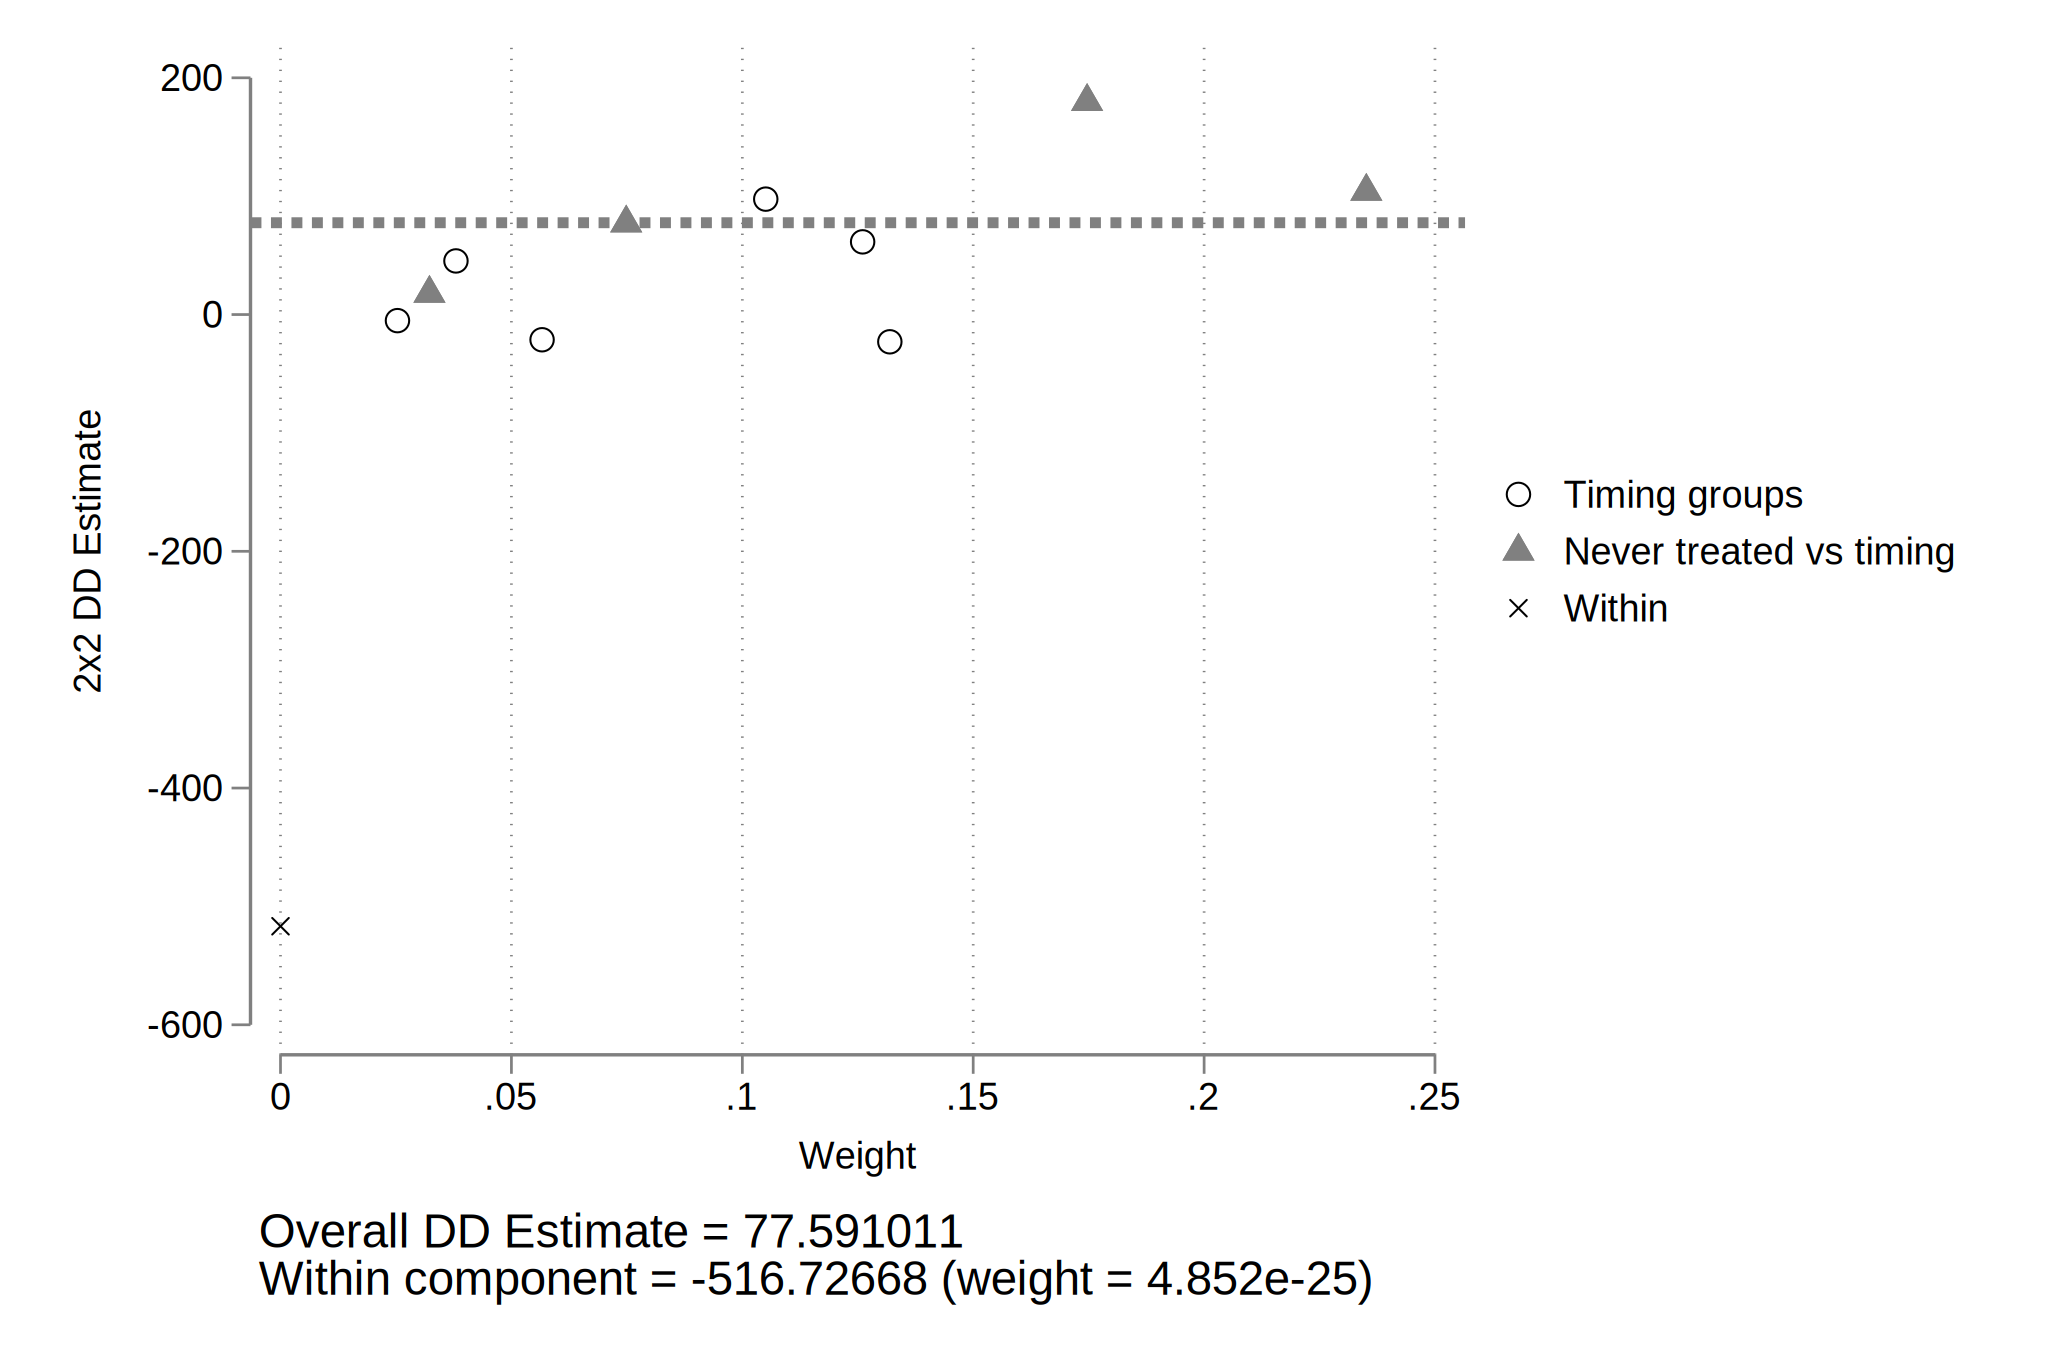

In [4]:
%%stata

bacondecomp Y D cohort, stub(_bac) robust ddetail

In [7]:
%%stata

csdid Y, ivar(id) time(t) gvar(gvar) notyet


. 
. csdid Y, ivar(id) time(t) gvar(gvar) notyet
..................................................
..................................................
..................................................
..................................................
....................................
Difference-in-difference with Multiple Time Periods

                                                         Number of obs = 1,800
Outcome model  : regression adjustment
Treatment model: none
------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
g24          |
       t_1_2 |  -.7045213    .567493    -1.24   0.214    -1.816787    .4077446
       t_2_3 |   .9186937   .7690364     1.19   0.232      -.58859    2.425977
       t_3_4 |  -.3697908   .6306189    -0.59   0.558    -1.605781    .8661996
       t_4_5 |  -.9509601  

       t_1_2 |   .8992041   .5013187     1.79   0.073    -.0833624    1.881771
       t_2_3 |  -.2242968   .8270641    -0.27   0.786    -1.845313    1.396719
       t_3_4 |  -.7248255   .8368735    -0.87   0.386    -2.365068    .9154164
       t_4_5 |   1.629056   .9878386     1.65   0.099     -.307072    3.565184
       t_5_6 |  -.8747413   .7631426    -1.15   0.252    -2.370473    .6209906
       t_6_7 |  -.7098175   .4237209    -1.68   0.094    -1.540295    .1206603
       t_7_8 |   1.193039   .5681553     2.10   0.036     .0794751    2.306603
       t_8_9 |  -.2300099   .7861562    -0.29   0.770    -1.770848    1.310828
      t_9_10 |  -.1605175   .7114717    -0.23   0.822    -1.554976    1.233941
     t_10_11 |   .0491926    .503466     0.10   0.922    -.9375826    1.035968
     t_11_12 |  -.5790652   .8717566    -0.66   0.507    -2.287677    1.129546
     t_12_13 |   .1745757   .4360408     0.40   0.689    -.6800486      1.0292
     t_13_14 |   .4088182   .7414068     0.55   0.58

Control: Not yet Treated

See Callaway and Sant'Anna (2021) for details

. 


In [8]:
%%stata

estat event, window(-10 10) estore(cs) 

// This tells Stata to store only the coefficients related to the 10 years prior and 
//the 10 years after the treatments


. 
. estat event, window(-10 10) estore(cs) 
ATT by Periods Before and After treatment
Event Study:Dynamic effects
------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     Pre_avg |   .0416478   .0426553     0.98   0.329     -.041955    .1252506
    Post_avg |   43.04438   1.193983    36.05   0.000     40.70422    45.38454
        Tm10 |   .3842823   .3615112     1.06   0.288    -.3242667    1.092831
         Tm9 |  -.1010115    .308461    -0.33   0.743    -.7055839    .5035609
         Tm8 |   .0338621   .3130682     0.11   0.914    -.5797404    .6474646
         Tm7 |   -.271289   .3434149    -0.79   0.430    -.9443698    .4017918
         Tm6 |   -.082143   .3231954    -0.25   0.799    -.7155943    .5513083
         Tm5 |   .0679468   .3355773     0.20   0.840    -.5897727    .7256663
         Tm4 | 


. 
. event_plot cs, default_look graph_opt(xtitle("Periods since the event") title
> ("csdid") ///
>                                       ytitle("Average effect") xlabel(-10(1)1
> 0)) ///
>                                      stub_lag(Tp#) stub_lead(Tm#) together

. 
. // what csdid does is it uses a robust methodology (optionally non-parametric
> , I think) to get the ATT estimate (average treatment effect on the treated) 
> but while only considering "good" designs. By good we mean either those that 
> identify ATT's correctly, or those that can be used for testing parallel tren
> ds. Most importatnly, it avoids estimating bad Did designs (i.e. those that u
> se previously treated units as the control group)
. 


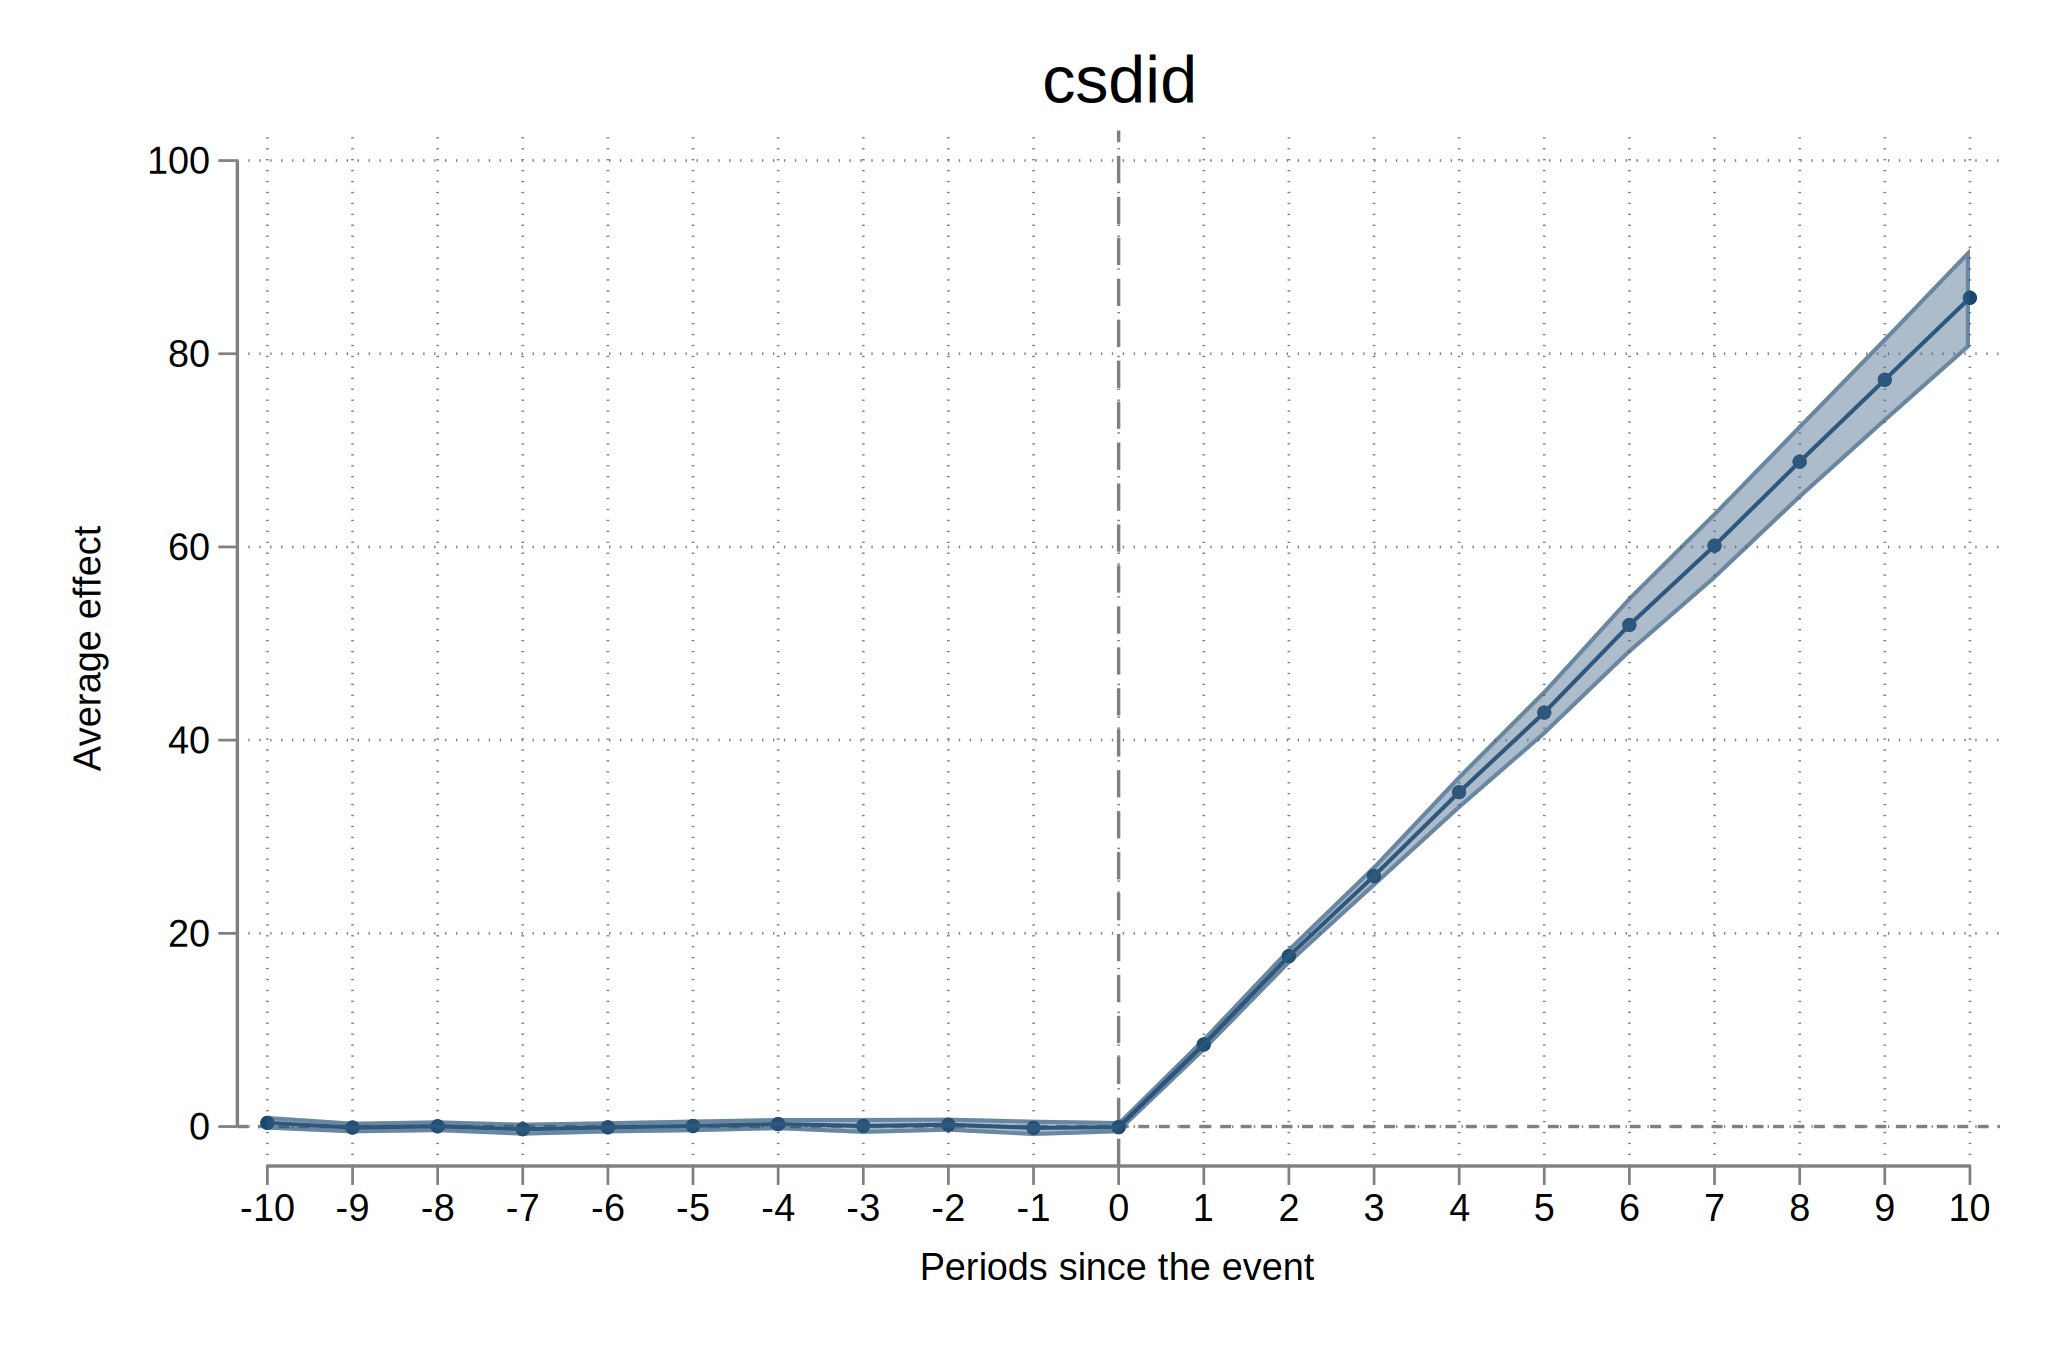

In [9]:
%%stata

event_plot cs, default_look graph_opt(xtitle("Periods since the event") title("csdid") ///
                                      ytitle("Average effect") xlabel(-10(1)10)) ///
                                     stub_lag(Tp#) stub_lead(Tm#) together

// what csdid does is it uses a robust methodology (optionally non-parametric, I think) to get 
//the ATT estimate (average treatment effect on the treated) but while only considering "good" designs.
//By good we mean either those that identify ATT's correctly, or those that can be used for testing parallel
//trends. Most importantly, it avoids estimating bad Did designs (i.e. those that use previously treated 
//units as the control group)


# • did_imputation


. 
. xtline Y, overlay legend(off)

. 


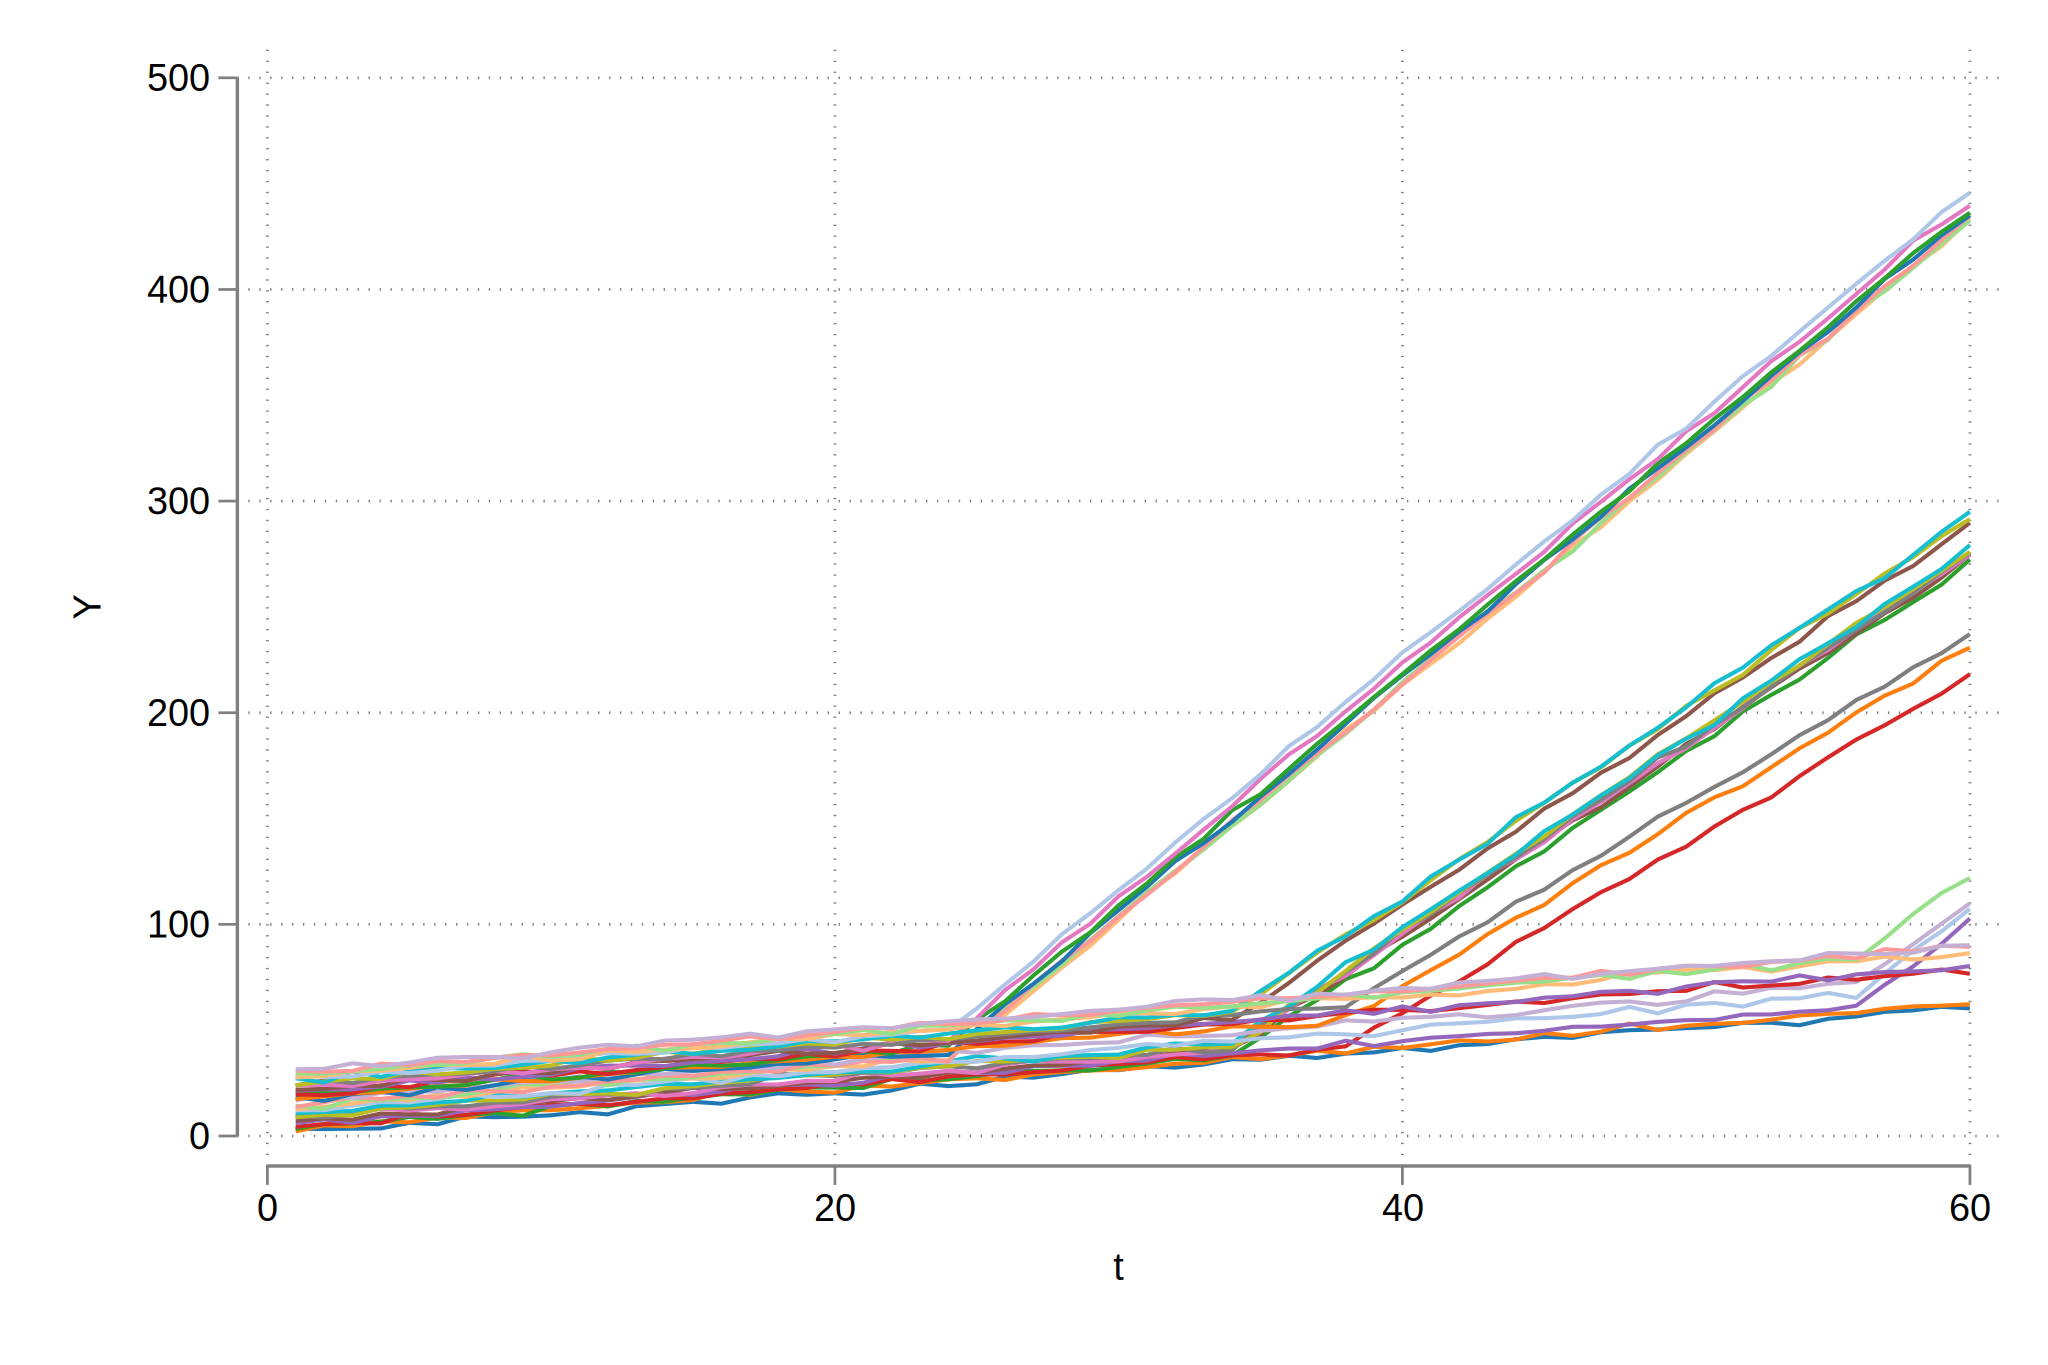

In [10]:
%%stata

xtline Y, overlay legend(off)


. 
. did_imputation Y id t first_treat, horizons(0/10) pretrend(10) 
> fficient effective sample size: tau0 tau1 tau2 tau3 tau4 tau5 tau6 tau7 tau8 
> tau9 tau10. To report them nevertheless, set the minn option to a smaller num
> ber or 0, but keep in mind that the estimates may be unreliable and their SE 
> may be downward biased.

                                                         Number of obs = 1,438
------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        tau0 |          0  (omitted)
        tau1 |          0  (omitted)
        tau2 |          0  (omitted)
        tau3 |          0  (omitted)
        tau4 |          0  (omitted)
        tau5 |          0  (omitted)
        tau6 |          0  (omitted)
        tau7 |          0  (omitted)
        tau8 |          0  (omitted)
        tau9 |

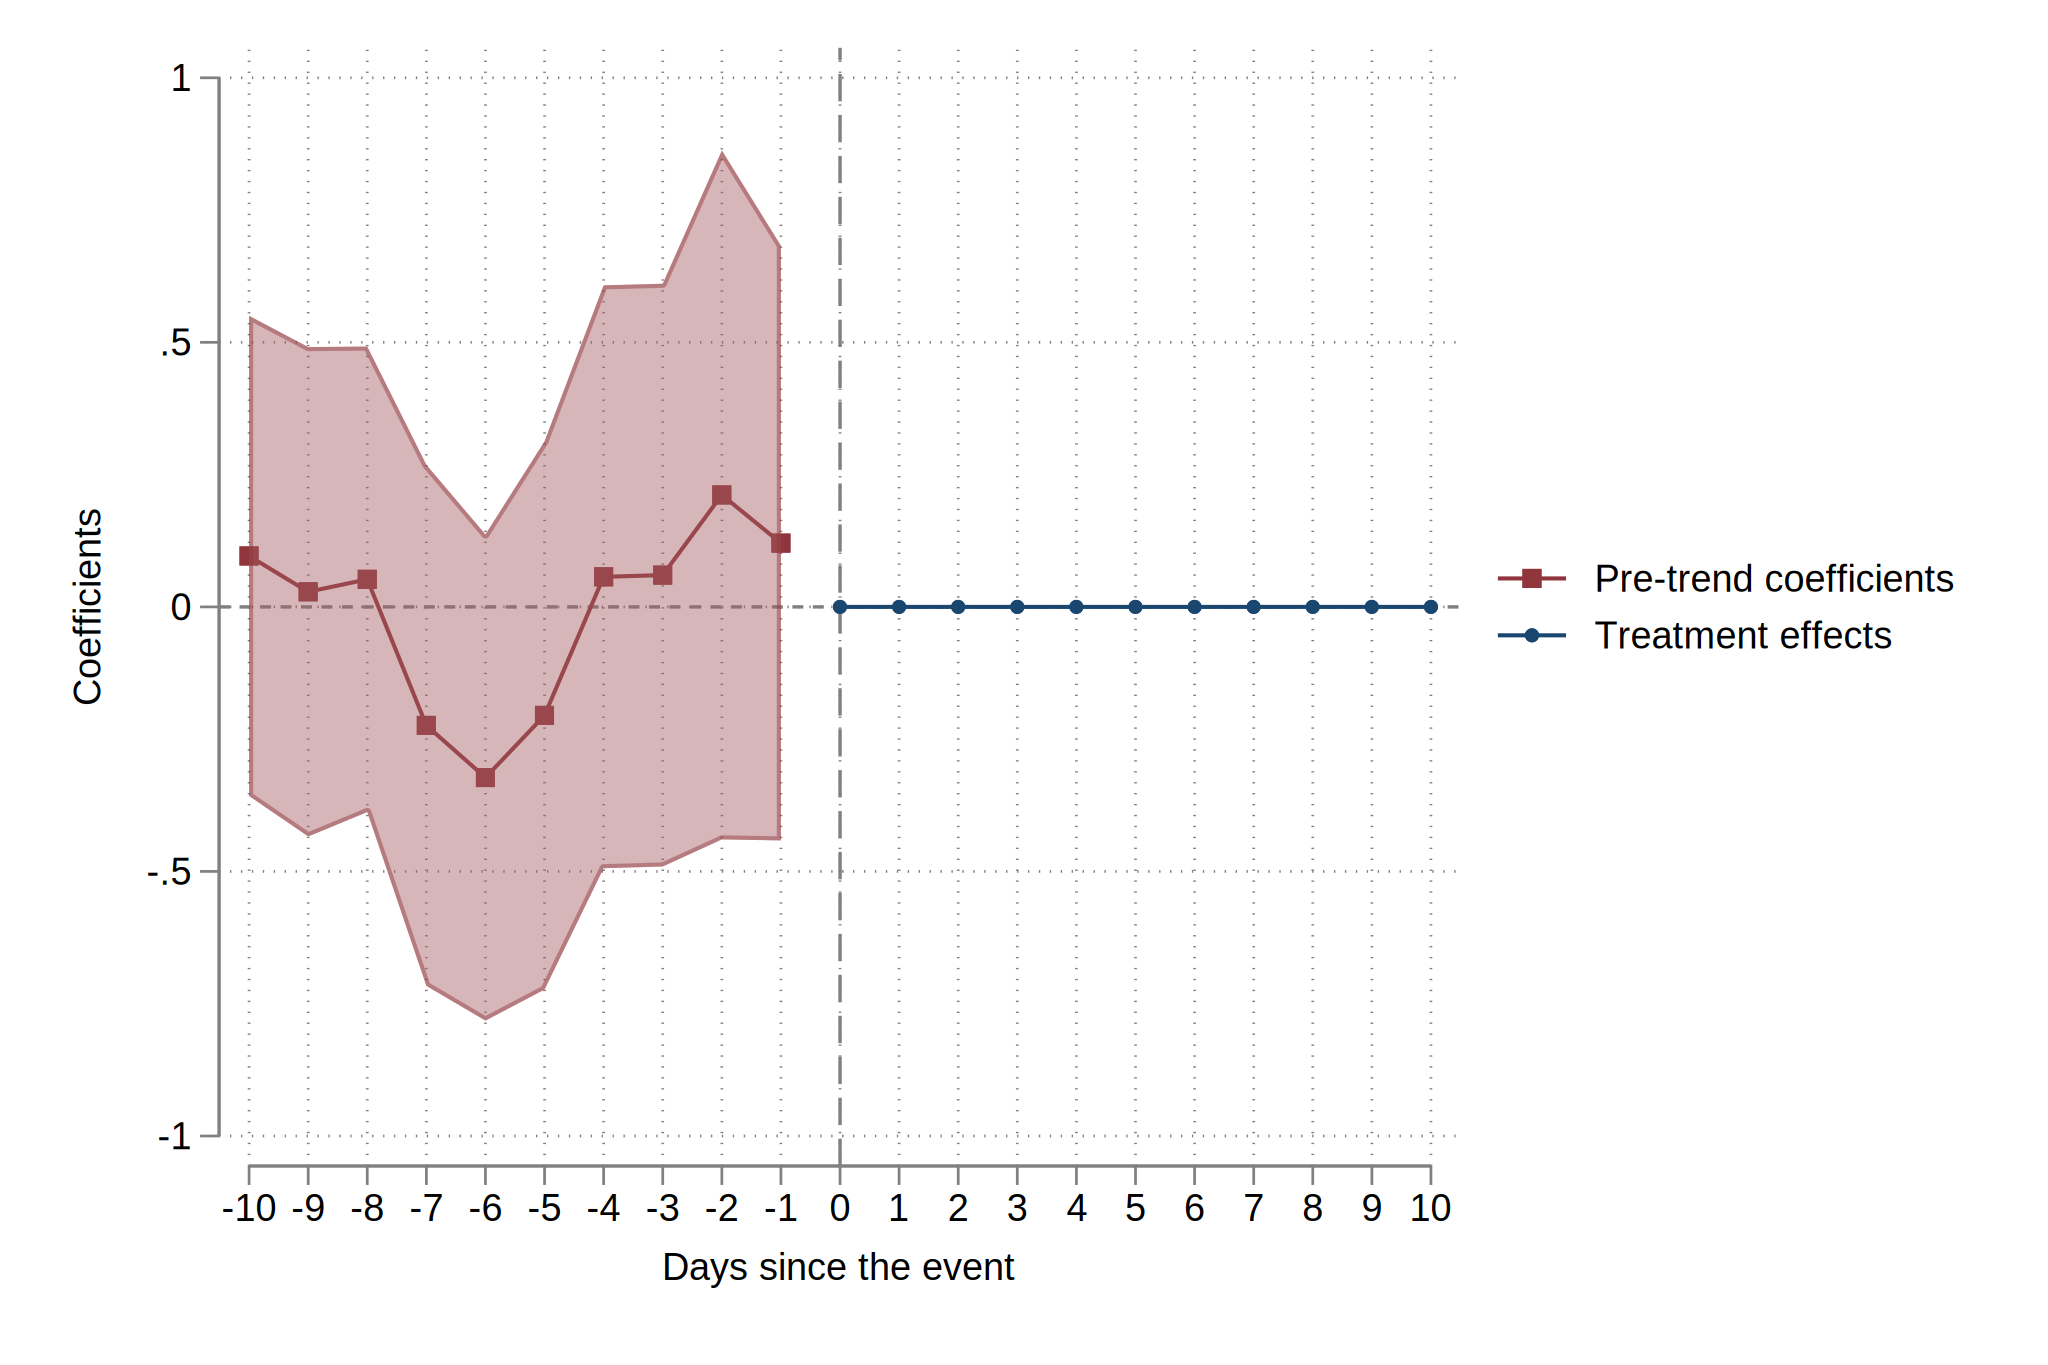

In [11]:
%%stata

did_imputation Y id t first_treat, horizons(0/10) pretrend(10) 

// This ^ tells Stata to do the imputation methodology where Y is the outcome avriable, 
//id is the unique unit id, t is the running time variable, and first_treat indicates
// the first date that the specific unit was treated

estimates store bjs 

// honestly I don't know why this works, but this stores the coefficients

event_plot, default_look graph_opt(xtitle("Days since the event") /// 
                                   ytitle("Coefficients") xlabel(-10(1)10))


. 
. // This minn(0) option is super important it says what is the minimum number
. //of observations that you want to require from each group? Any group below
. //that minimum number will have its coefficient supressed 
. 
. did_imputation Y id t first_treat, horizons(0/10) pretrend(10) minn(0)

                                                         Number of obs = 1,438
------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        tau0 |   .0787163   .2677837     0.29   0.769      -.44613    .6035626
        tau1 |   8.637227   .2815466    30.68   0.000     8.085406    9.189048
        tau2 |   17.78728   .2329168    76.37   0.000     17.33078    18.24379
        tau3 |   26.07725   .2293303   113.71   0.000     25.62777    26.52673
        tau4 |   34.76562   .2815757   123.47   0.000     34.21374   

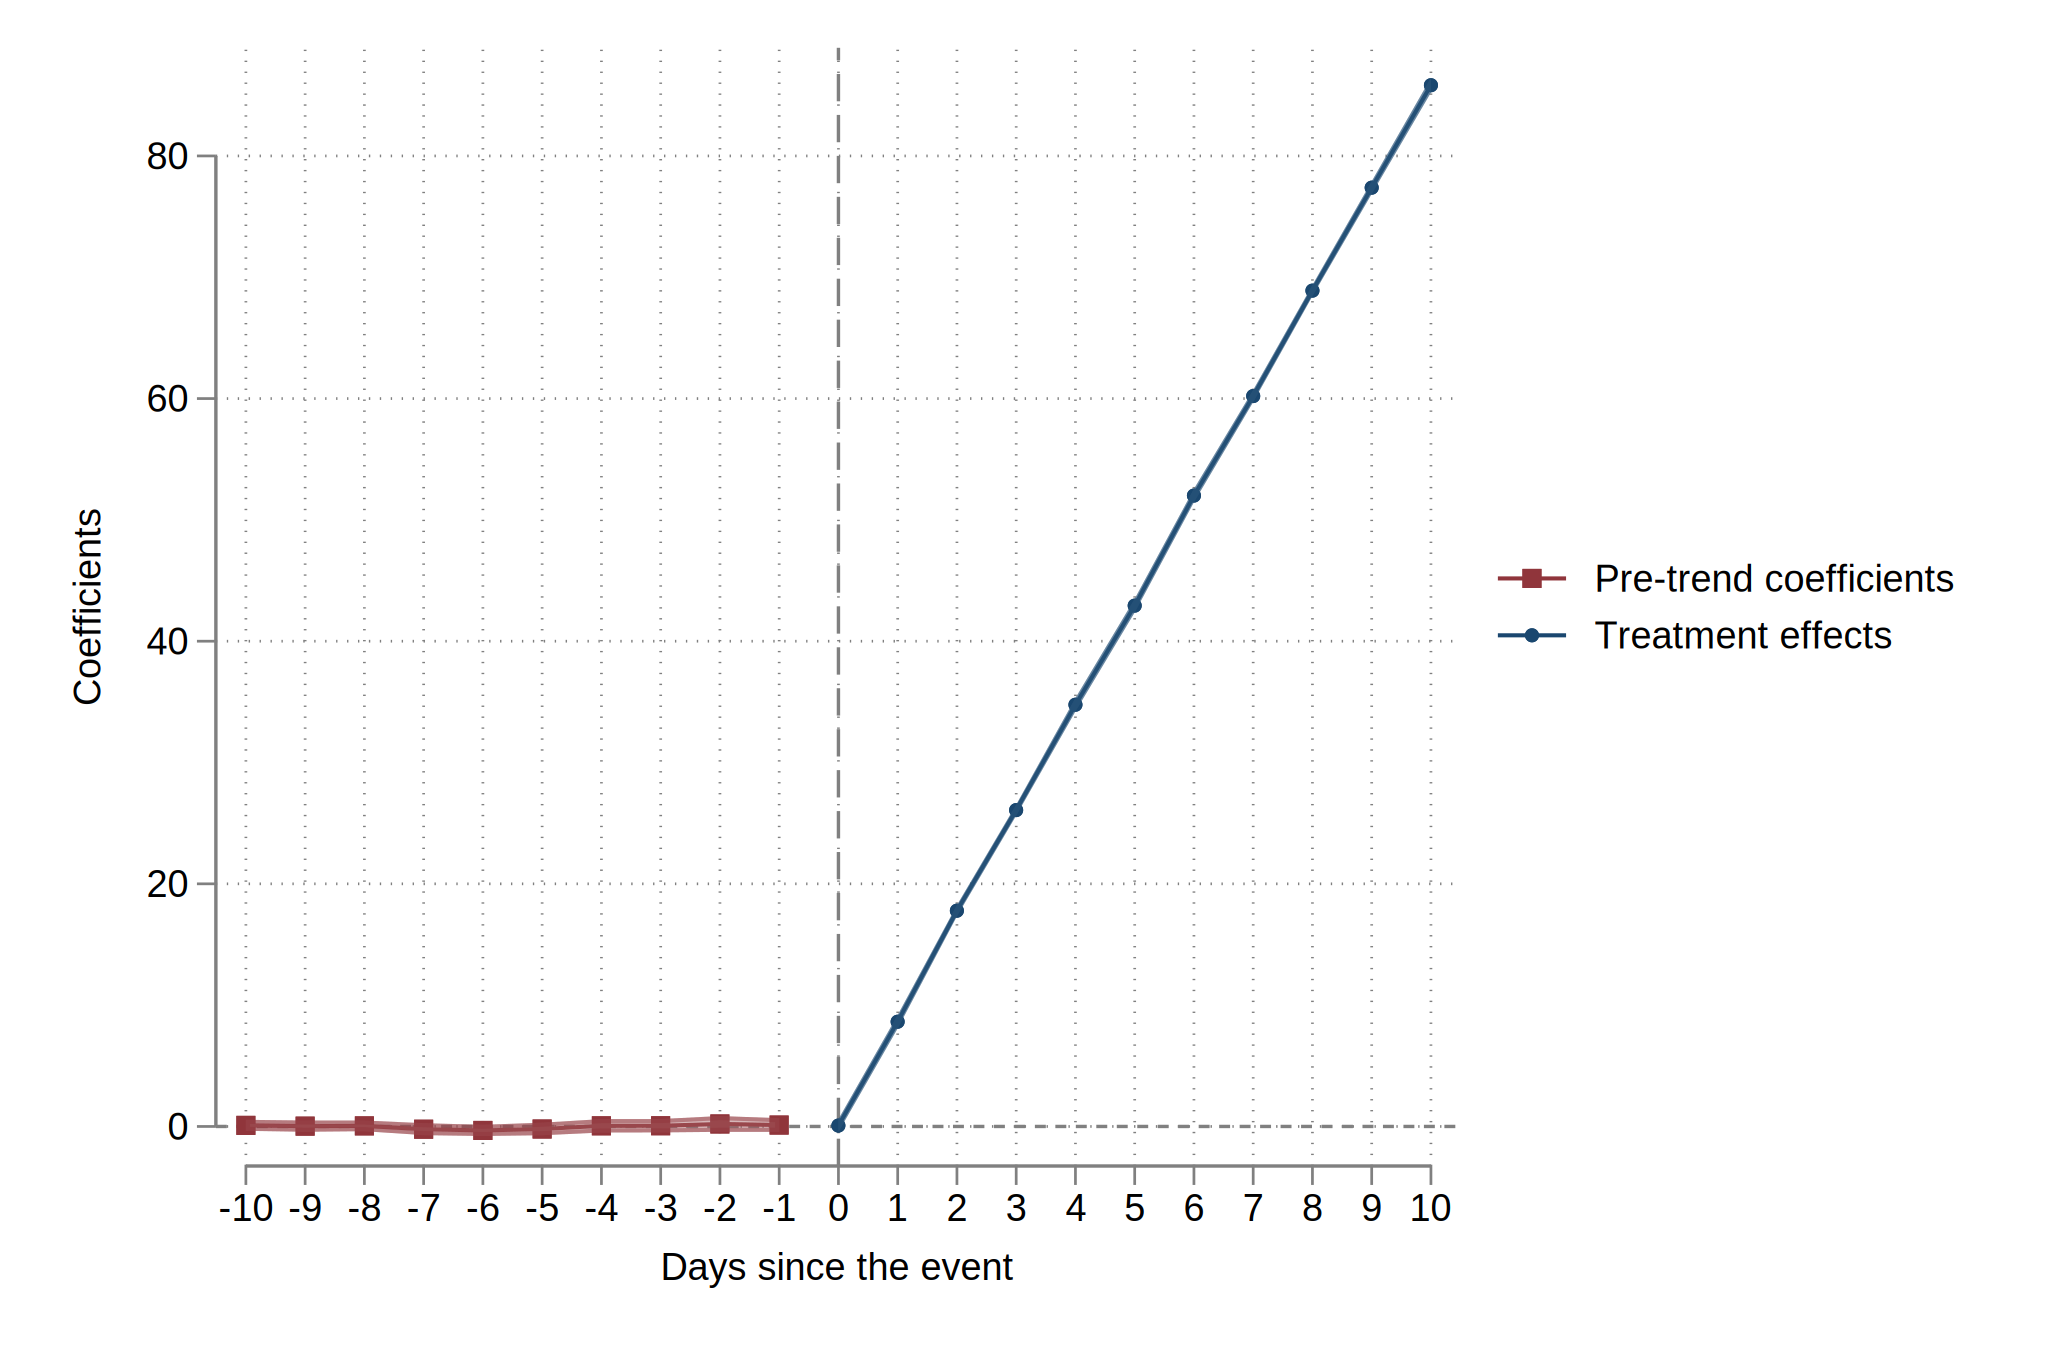

In [12]:
%%stata

// This minn(0) option is super important it says what is the minimum number
//of observations that you want to require from each group? Any group below
//that minimum number will have its coefficient supressed 

did_imputation Y id t first_treat, horizons(0/10) pretrend(10) minn(0)
estimates store bjs 
 event_plot, default_look graph_opt(xtitle("Days since the event") ///
                                    ytitle("Coefficients") xlabel(-10(1)10))



. 
.  // Just as a comparison
.     
. did_imputation Y id t first_treat, horizons(0/10) pretrend(10) minn(20) 
> fficient effective sample size: tau5 tau6 tau7 tau8 tau9 tau10. To report the
> m nevertheless, set the minn option to a smaller number or 0, but keep in min
> d that the estimates may be unreliable and their SE may be downward biased.

                                                         Number of obs = 1,438
------------------------------------------------------------------------------
           Y | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        tau0 |   .0787163   .2677837     0.29   0.769      -.44613    .6035626
        tau1 |   8.637227   .2815466    30.68   0.000     8.085406    9.189048
        tau2 |   17.78728   .2329168    76.37   0.000     17.33078    18.24379
        tau3 |   26.07725   .2293303   113.71   0.000     25.62777    26.52673
        tau4 |  

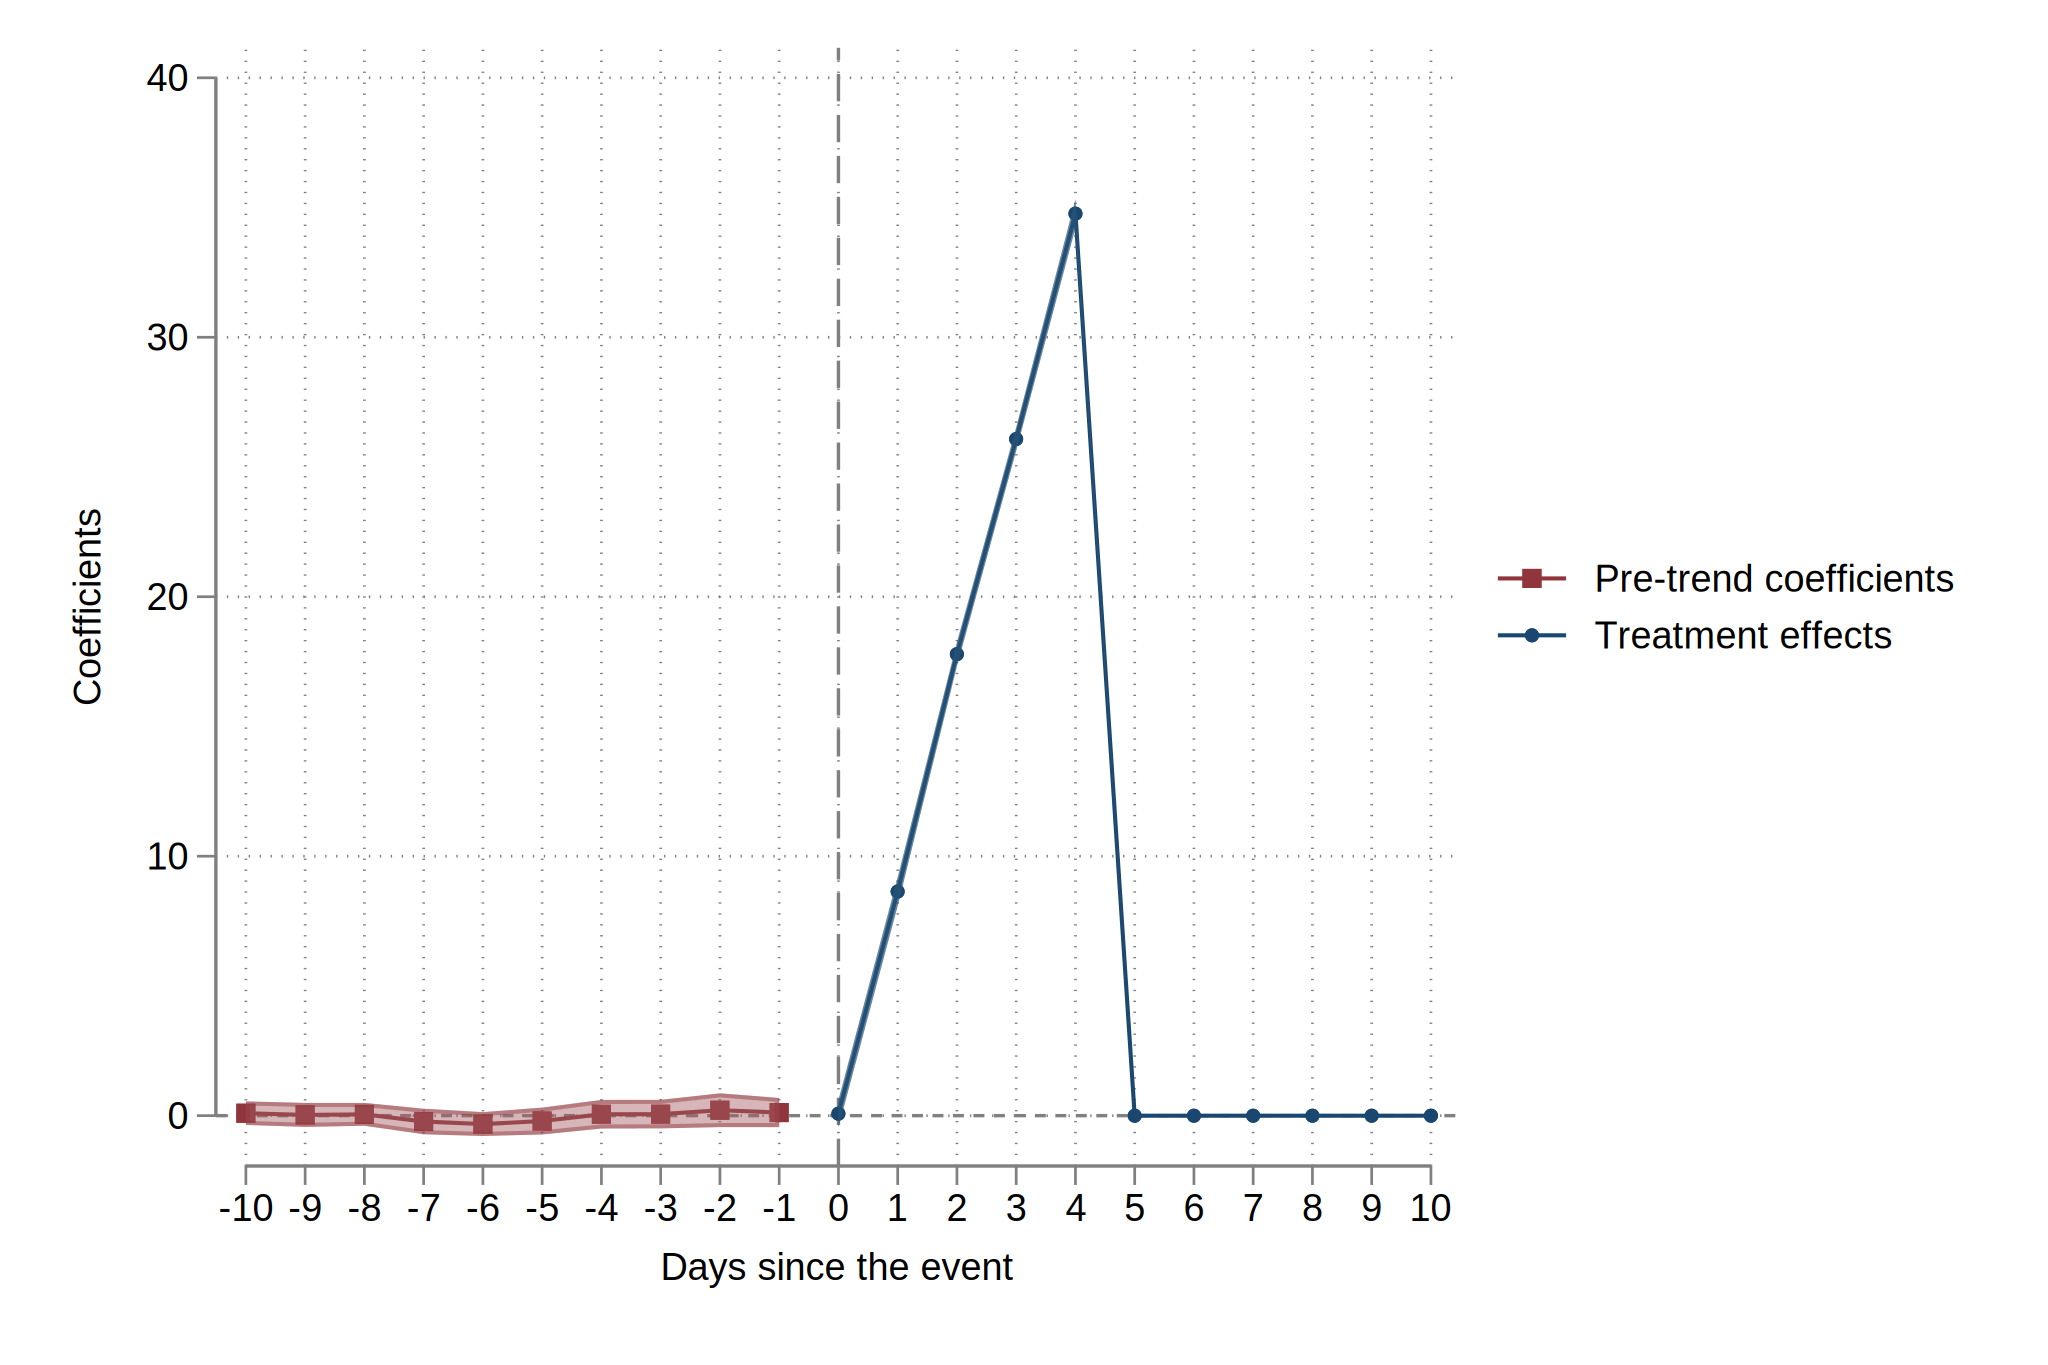

In [13]:
%%stata

 // Just as a comparison
    
did_imputation Y id t first_treat, horizons(0/10) pretrend(10) minn(20) 
estimates store bjs 
event_plot, default_look graph_opt(xtitle("Days since the event") ///
                                    ytitle("Coefficients") xlabel(-10(1)10))

### What the did_imputation is doing is following Borusyak et al. (2021) where to deal with heterogeneity of treatment effects (in a staggered treatment scenario), the efficient robust estimator is implemented by using an "imputation" procedure, where first the unit and period fixed effects ($\hat{\alpha}_i$ and $\hat{\beta}_i$) are fitted by regressions using unreated observations only. Second, these fixed effects are used to impute the untreated potential outcomes and therefore obtain the estimated treatment effects $\hat{\tau}_{it} = Y_{it}-\hat{\alpha}_i - \hat{\beta}_i $ for each treated observation. Finally, a weighted sum of these treatment effect estimates is taken

# • In-class example

In [14]:
%%stata


 use"https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.dta", clear


. 
. 
.  use"https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master
> /Model_Estimation/Data/Event_Study_DiD/bacon_example.dta", clear
(Stevenson and Wolfers (2006) divorce example, provided by Goldring et al.)

. 


In [15]:
%%stata

gen treated=_nfd!=.
 
reg asmrs i.treated##i.post

 
gen interaction=post*treated

reg asmrs interaction post treated 


. 
. gen treated=_nfd!=.

.  
. reg asmrs i.treated##i.post

      Source |       SS           df       MS      Number of obs   =     1,617
-------------+----------------------------------   F(3, 1613)      =     27.74
       Model |  30523.6898         3  10174.5633   Prob > F        =    0.0000
    Residual |  591665.424     1,613  366.810554   R-squared       =    0.0491
-------------+----------------------------------   Adj R-squared   =    0.0473
       Total |  622189.114     1,616  385.018016   Root MSE        =    19.152

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
   1.treated |   14.92364   1.812819     8.23   0.000     11.36791    18.47937
      1.post |   5.007667   1.900665     2.63   0.009     1.279635      8.7357
             |
treated#post |
        1 1  |  -13.26821   2.260724  

In [16]:
%%stata


xtreg asmrs i.treated##i.post i.year, i(stfips)  fe 

// This is saying run a fixed effects model "fe" using i(sstfips) 
//as the fixed effect. In order to add the second FE use i.year 
//(note you could flip the two, and do i.stfips and wirte i(year) after the comma)
 


. 
. 
. xtreg asmrs i.treated##i.post i.year, i(stfips)  fe 
note: 1.treated omitted because of collinearity.
note: 1.treated#1.post omitted because of collinearity.

Fixed-effects (within) regression               Number of obs     =      1,617
Group variable: stfips                          Number of groups  =         49

R-squared:                                      Obs per group:
     Within  = 0.3461                                         min =         33
     Between = 0.0293                                         avg =       33.0
     Overall = 0.1462                                         max =         33

                                                F(33,1535)        =      24.62
corr(u_i, Xb) = -0.0240                         Prob > F          =     0.0000

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----------------------------------------

In [17]:
%%stata


 tab year, gen(Y) //tabluates and generates dummy variables for the years
 tab stfip, gen(st)  //


. 
. 
.  tab year, gen(Y) //tabluates and generates dummy variables for the years

       Year |      Freq.     Percent        Cum.
------------+-----------------------------------
       1964 |         49        3.03        3.03
       1965 |         49        3.03        6.06
       1966 |         49        3.03        9.09
       1967 |         49        3.03       12.12
       1968 |         49        3.03       15.15
       1969 |         49        3.03       18.18
       1970 |         49        3.03       21.21
       1971 |         49        3.03       24.24
       1972 |         49        3.03       27.27
       1973 |         49        3.03       30.30
       1974 |         49        3.03       33.33
       1975 |         49        3.03       36.36
       1976 |         49        3.03       39.39
       1977 |         49        3.03       42.42
       1978 |         49        3.03       45.45
       1979 |         49        3.03       48.48
       1980 |         49        3.

In [20]:
%%stata

 reghdfe asmrs interaction, abs(stf year) 
    // This is a much nicer command, with prettier  output



. 
.  reghdfe asmrs interaction, abs(stf year) 
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =      1,617
Absorbing 2 HDFE groups                           F(   1,   1535) =       7.68
                                                  Prob > F        =     0.0057
                                                  R-squared       =     0.7007
                                                  Adj R-squared   =     0.6849
                                                  Within R-sq.    =     0.0050
                                                  Root MSE        =    11.0143

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
 interaction |  -3.079926   1.111656    -2.77   0.006    -5.260452   -.8993999
       _cons |   53.77209   .6410134 

In [21]:
%%stata

reg asmrs inter  st2-st49 Y2-Y33 
//again, an alternative, but it looks horrible
 


. 
. reg asmrs inter  st2-st49 Y2-Y33 

      Source |       SS           df       MS      Number of obs   =     1,617
-------------+----------------------------------   F(81, 1535)     =     44.37
       Model |  435971.652        81  5382.36608   Prob > F        =    0.0000
    Residual |  186217.461     1,535  121.314307   R-squared       =    0.7007
-------------+----------------------------------   Adj R-squared   =    0.6849
       Total |  622189.114     1,616  385.018016   Root MSE        =    11.014

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
 interaction |  -3.079926   1.111656    -2.77   0.006    -5.260452   -.8993999
         st2 |   33.01081   2.712365    12.17   0.000     27.69048    38.33115
         st3 |  -.5985092   2.849473    -0.21   0.834    -6.187781    4.990762
         s

In [23]:
%%stata

reghdfe asmrs interaction, abs(stfips year) 

//Instead of regressing on the interaction,
//you could regress on the "post" variable and get the same result



. 
. reghdfe asmrs interaction, abs(stfips year) 
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =      1,617
Absorbing 2 HDFE groups                           F(   1,   1535) =       7.68
                                                  Prob > F        =     0.0057
                                                  R-squared       =     0.7007
                                                  Adj R-squared   =     0.6849
                                                  Within R-sq.    =     0.0050
                                                  Root MSE        =    11.0143

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
 interaction |  -3.079926   1.111656    -2.77   0.006    -5.260452   -.8993999
       _cons |   53.77209   .641013

In [24]:
%%stata


gen nfd_missing=_nfd
 
gen exp=year-_nfd
*make sure untreated units are included
*but get no dummies (by giving them "-1")

recode exp (.=-1) (-1000/-6=-6) (12/1000=12) // honestly not sure what this does

char exp[omit] -1
xi i.exp, pref(_T) // xi provides a convenient way to
                    // convert categorical variables to 
                    //dummy or indicator variables when you fit a model. 
                    //pref() sets the prefix of the string



. 
. 
. gen nfd_missing=_nfd
(429 missing values generated)

.  
. gen exp=year-_nfd
(429 missing values generated)

. *make sure untreated units are included
. *but get no dummies (by giving them "-1")
. 
. recode exp (.=-1) (-1000/-6=-6) (12/1000=12) // honestly not sure what this d
> oes
(936 changes made to exp)

. 
. char exp[omit] -1

. xi i.exp, pref(_T) // xi provides a convenient way to
i.exp             _Texp_1-19          (_Texp_6 for exp==-1 omitted)

.                     // convert categorical variables to 
.                     //dummy or indicator variables when you fit a model. 
.                     //pref() sets the prefix of the string
. 


In [25]:
%%stata

reghdfe asmrs _Texp_1-_Texp_5 _Texp_7-_Texp_19 pcinc asmrh cases, abs(stfips year) //
//excluding period 6 as the ommitted period


. 
. reghdfe asmrs _Texp_1-_Texp_5 _Texp_7-_Texp_19 pcinc asmrh cases,abs(stfips y
> ear) 
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =      1,617
Absorbing 2 HDFE groups                           F(  21,   1515) =       4.38
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.7164
                                                  Adj R-squared   =     0.6975
                                                  Within R-sq.    =     0.0572
                                                  Root MSE        =    10.7918

------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
     _Texp_1 |  -2.127375   2.239316    -0.95   0.342    -6.519863    2.2

In [26]:
%%stata


gen coef=.
gen se=. 

forvalues i=1(1)5{
	
	replace coef=_b[_Texp_`i'] if _Texp_`i'==1
	
	replace se=_se[_Texp_`i'] if _Texp_`i'==1
	
}

                   
forvalues i=7(1)19{
	
	replace coef=_b[_Texp_`i'] if _Texp_`i'==1
	
	replace se=_se[_Texp_`i'] if _Texp_`i'==1
	
}

g ci_top = coef+1.96*se //Storing the coefficients and their standard errors for
                       //a coefficient plot
g ci_bottom = coef - 1.96*se
                   



. 
. 
. gen coef=.
(1,617 missing values generated)

. gen se=. 
(1,617 missing values generated)

. 
. forvalues i=1(1)5{
  2.         
.         replace coef=_b[_Texp_`i'] if _Texp_`i'==1
  3.         
.         replace se=_se[_Texp_`i'] if _Texp_`i'==1
  4.         
. }
(165 real changes made)
(165 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)

. 
.                    
. forvalues i=7(1)19{
  2.         
.         replace coef=_b[_Texp_`i'] if _Texp_`i'==1
  3.         
.         replace se=_se[_Texp_`i'] if _Texp_`i'==1
  4.         
. }
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes made)
(36 real changes m


. 
. //Event study plot:
. 
. twoway (scatter  coef  exp , lcolor(blue))  (rcap  ci_top ci_bot exp, lcolor(
> blue)) , yline(0,lcolor(black black black))  ///
> subtitle("",  j(left) pos(11)) xlabel(-7(1)10, labsize(small)) xtitle("Years 
> Relative to Divorce Reform", ) yscale(range(-15(1)5)) ylabel(-15(5)5,nogrid a
> ngle(horizontal) labsize(small)) ///
> legend(off) graphregion(color(white)) saving("x",replace) ytitle("Suicides pe
> r 1m Women") xline(-1,lcolor(black)) xlabel(-5(1)12) yline(-3.08,lcolor(red) 
> lwidth(thick)) 
(note:  named style black black black not found in class color, default
    attributes used)
(file x.gph not found)
file x.gph saved

. 


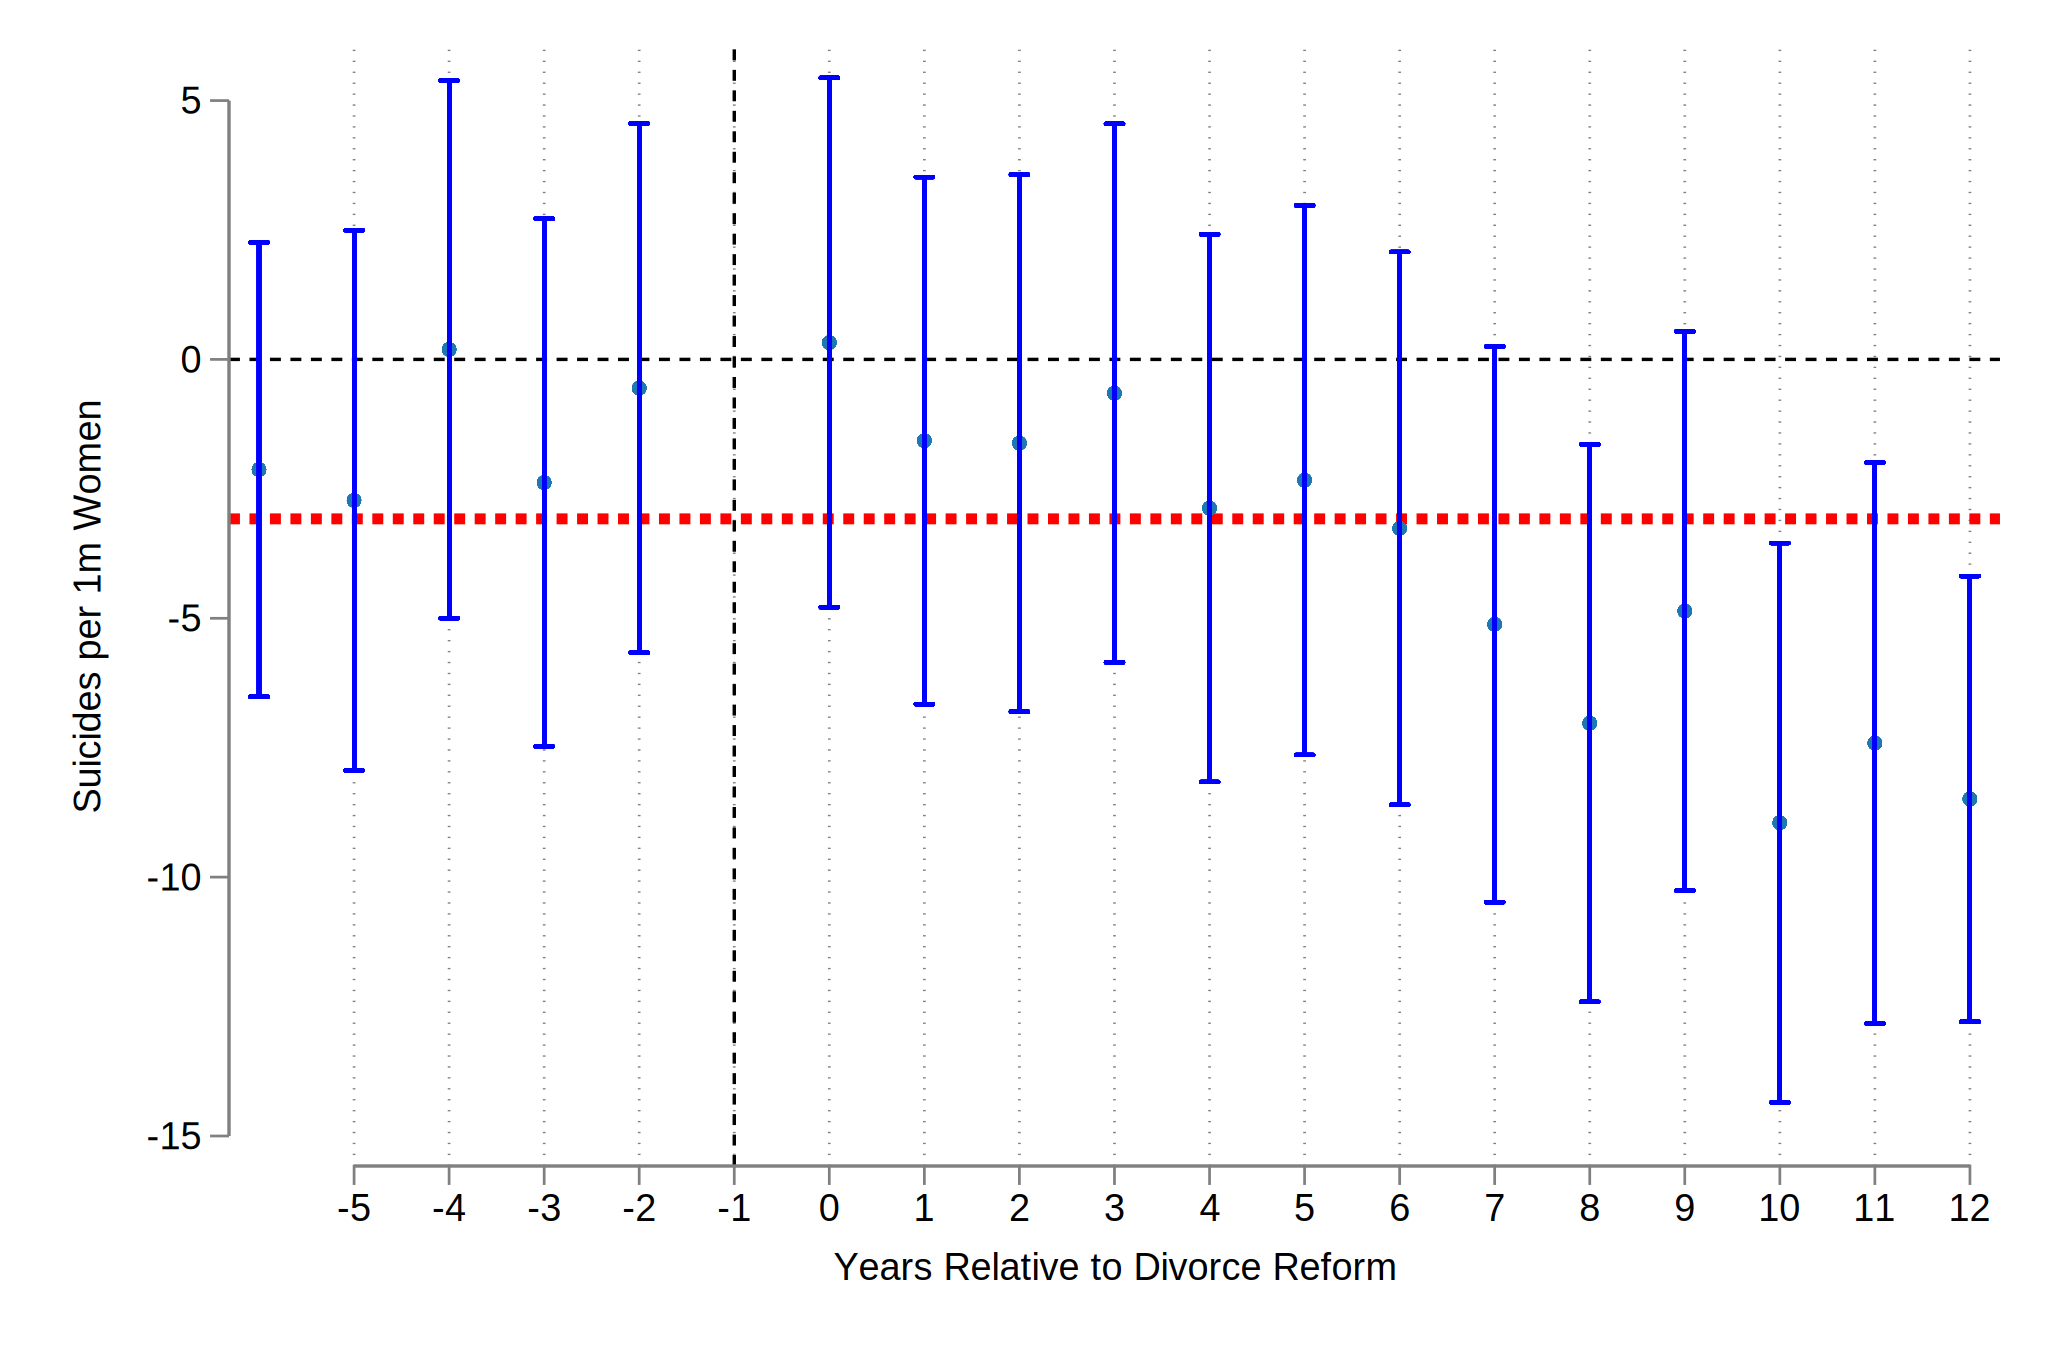

In [27]:
%%stata

//Event study plot:

twoway (scatter  coef  exp , lcolor(blue))  (rcap  ci_top ci_bot exp, lcolor(blue)) , yline(0,lcolor(black black black))  ///
subtitle("",  j(left) pos(11)) xlabel(-7(1)10, labsize(small)) xtitle("Years Relative to Divorce Reform", ) yscale(range(-15(1)5)) ylabel(-15(5)5,nogrid angle(horizontal) labsize(small)) ///
legend(off) graphregion(color(white)) saving("x",replace) ytitle("Suicides per 1m Women") xline(-1,lcolor(black)) xlabel(-5(1)12) yline(-3.08,lcolor(red) lwidth(thick)) 


In [32]:
%%stata

gen first_treat=_nfd-1969
 
replace first_treat=0 if _nfd==. & treated==0
 

gen _nfd2=_nfd
replace _nfd2=0 if _nfd==.



. 
. gen first_treat=_nfd-1969
(429 missing values generated)

.  
. replace first_treat=0 if _nfd==. & treated==0
(429 real changes made)

.  
. 
. gen _nfd2=_nfd
(429 missing values generated)

. replace _nfd2=0 if _nfd==.
(429 real changes made)

. 


In [ ]:
******************************************
*              Exercise 1                *
****************************************** 

UsageError: Line magic function `%browse` not found.


In [33]:
%%stata

// bacondecomp is a tool to help us visualize which comparisons are being 
//heavily weighted in the twoway fixed effects estimation
// use reghdfe to estimate the twoway fixed effects coefficeint for the treatment
// remember to control for per-capita income, homicide mortality, AFDC cases, state and year fixed effects (don't forget the interaction term)

reghdfe asmrs interaction pcinc asmrh cases,abs(stfips year)


. 
. // bacondecomp is a tool to help us visualize which comparisons are being 
. //heavily weighted in the twoway fixed effects estimation
. // use reghdfe to estimate the twoway fixed effects coefficeint for the treat
> ment
. // remember to control for per-capita income, homicide mortality, AFDC cases,
>  state and year fixed effects (don't forget the interaction term)
. 
. reghdfe asmrs interaction pcinc asmrh cases,abs(stfips year)
(MWFE estimator converged in 2 iterations)

HDFE Linear regression                            Number of obs   =      1,617
Absorbing 2 HDFE groups                           F(   4,   1532) =      13.73
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.7096
                                                  Adj R-squared   =     0.6937
                                                  Within R-sq.    =     0.0346
                                        


. 
. // run bacondecomp on the same regression you just ran above 
. bacondecomp asmrs post pcinc asmrh cases, stub(Bacon_) robust ddetail
Computing decomposition across 14 timing groups
including an always-treated group and a never-treated group
------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        post |  -2.515964   2.283101    -1.10   0.270     -6.99076    1.958833
------------------------------------------------------------------------------

Bacon Decomposition

+---------------------------------------------------+
|                      |         Beta   TotalWeight |
|----------------------+----------------------------|
|        Timing_groups |  2.602167327   .3776606651 |
|      Always_v_timing |  -7.02043576   .3783086972 |
|       Never_v_timing | -5.256988806   .2389229013 |
|       Alw

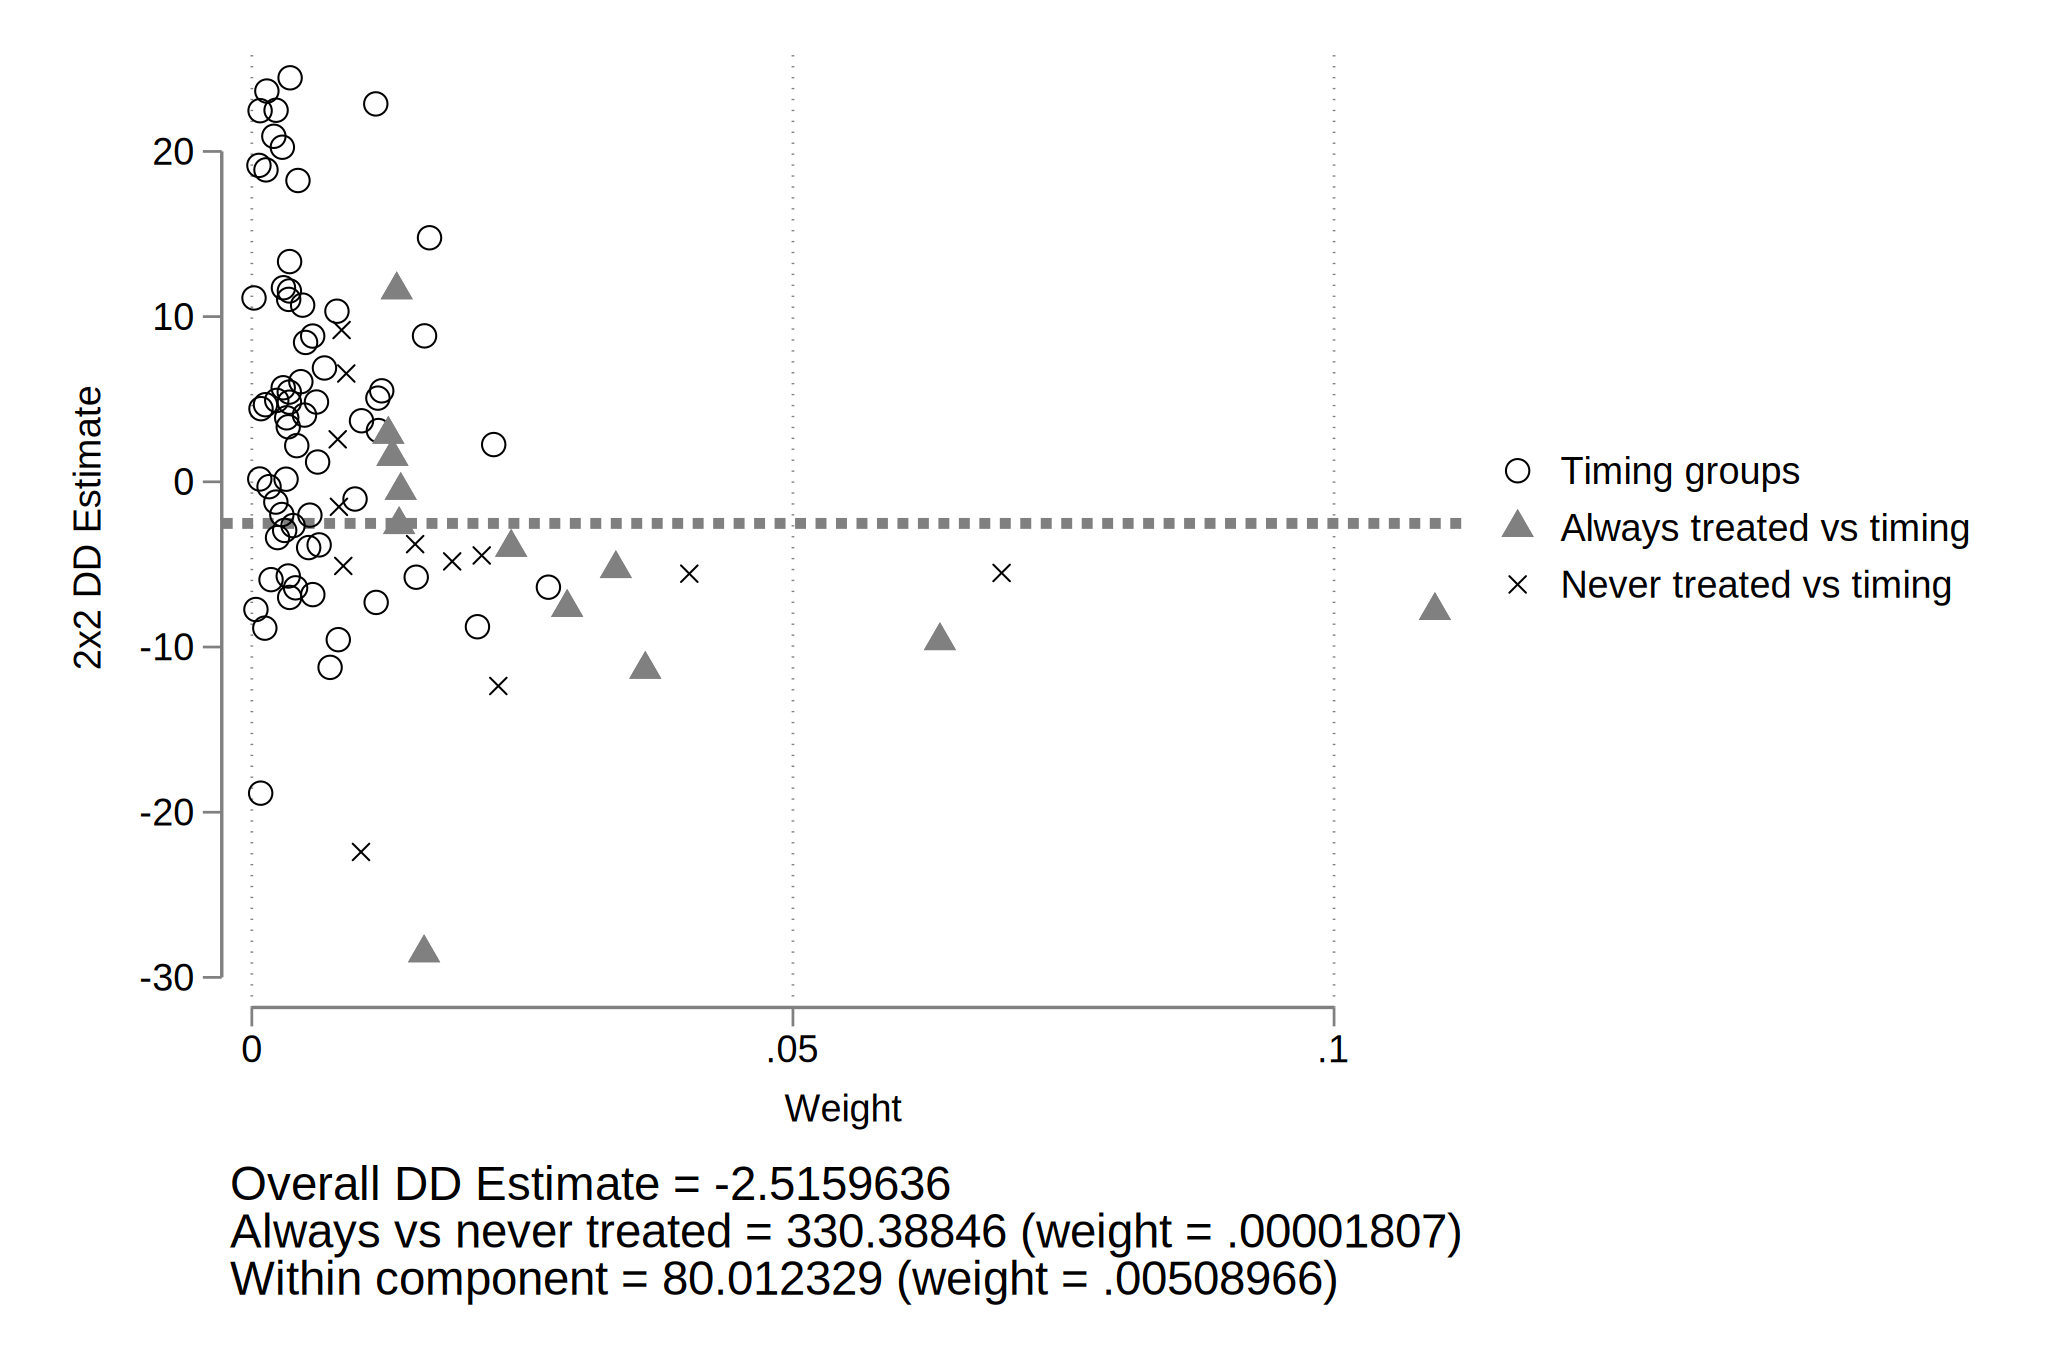

In [34]:
%%stata

// run bacondecomp on the same regression you just ran above 
bacondecomp asmrs post pcinc asmrh cases, stub(Bacon_) robust ddetail


In [35]:
%%stata

// List the "stub" variables/tables you created
list Bacon_T Bacon_C Bacon_B Bacon_cgroup if !mi(Bacon_T)
 


. 
. // List the "stub" variables/tables you created
. list Bacon_T Bacon_C Bacon_B Bacon_cgroup if !mi(Bacon_T)

      +---------------------------------------------------------+
      | Bacon_T   Bacon_C    Bacon_B               Bacon_cgroup |
      |---------------------------------------------------------|
   1. |  Timing    Groups   -18.8461              Timing groups |
   2. |  Timing    Groups   -6.82611              Timing groups |
   3. |  Timing    Groups    20.2554              Timing groups |
   4. |  Timing    Groups   -5.69867              Timing groups |
   5. |  Timing    Groups    22.4959              Timing groups |
      |---------------------------------------------------------|
   6. |  Timing    Groups   -6.41586              Timing groups |
   7. |  Timing    Groups   -5.77195              Timing groups |
   8. |  Timing    Groups    22.8784              Timing groups |
   9. |  Timing    Groups   -6.37595              Timing groups |
  10. |  Timing    Groups  


. 
. // plot the asmrs lines 
. xtline asmrs, overlay legend(off)

. 


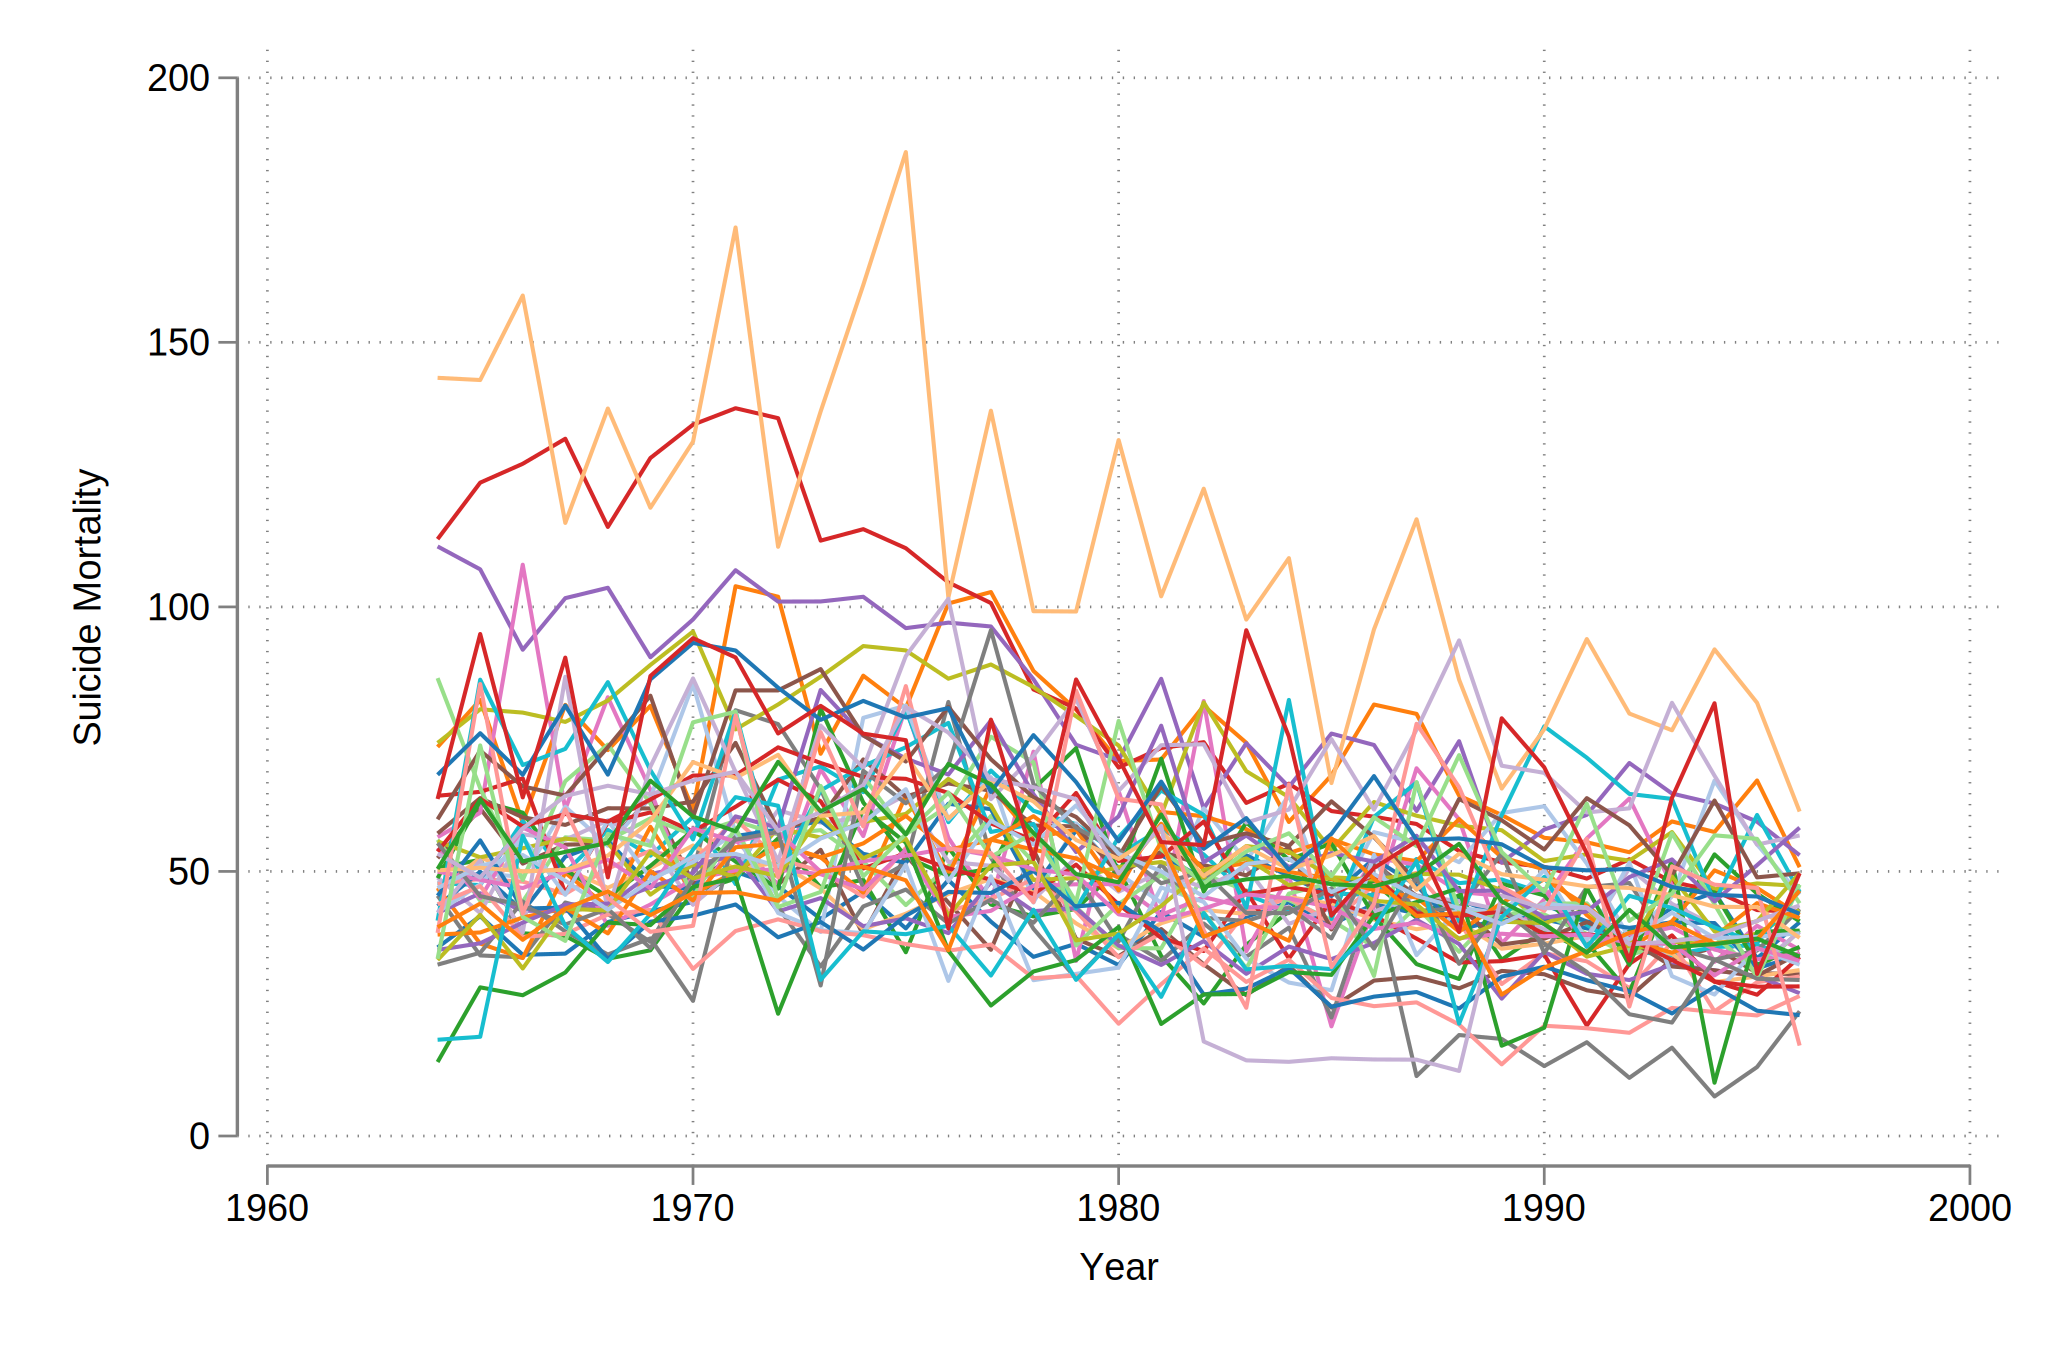

In [36]:
%%stata

// plot the asmrs lines 
xtline asmrs, overlay legend(off)

In [ ]:
******************************************
*              Exercise 2                *
****************************************** 

In [37]:
%%stata

// use csdid to calculate the corrected coefficient

csdid asmrs, ivar(stf) time(year) gvar(_nfd2) notyet 
// can remove the notyet option as well, but the results change a bit
estat all 



. 
. // use csdid to calculate the corrected coefficient
. 
. csdid asmrs, ivar(stf) time(year) gvar(_nfd2) notyet 
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................
Difference-in-difference with Multiple Time Periods

                                                         Number of obs = 1,617
Outcome model  : regression adjustment
Treatment model: none
------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
g1969        |
 t_1964_1965 |  -4.727176   5.718247    -0.83 

 t_1970_1971 |  -8.725292   2.814332    -3.10   0.002    -14.24128   -3.209302
 t_1971_1972 |   9.475352   2.948607     3.21   0.001     3.696188    15.25452
 t_1972_1973 |  -5.685641   4.233953    -1.34   0.179    -13.98404    2.612754
 t_1973_1974 |  -.1363619   2.823384    -0.05   0.961    -5.670093    5.397369
 t_1973_1975 |   1.593054   4.383254     0.36   0.716    -6.997965    10.18407
 t_1973_1976 |  -1.798938   3.737486    -0.48   0.630    -9.124277      5.5264
 t_1973_1977 |  -2.079912   5.268216    -0.39   0.693    -12.40542    8.245601
 t_1973_1978 |  -2.802432   5.164116    -0.54   0.587    -12.92391     7.31905
 t_1973_1979 |   .0595144   3.610123     0.02   0.987    -7.016197    7.135226
 t_1973_1980 |  -4.794045   4.704485    -1.02   0.308    -14.01467    4.426577
 t_1973_1981 |   -4.07174   4.755216    -0.86   0.392    -13.39179    5.248311
 t_1973_1982 |   3.254496   4.932587     0.66   0.509    -6.413197    12.92219
 t_1973_1983 |    2.24916   6.849957     0.33   0.74

 t_1969_1970 |   10.48373    2.73969     3.83   0.000     5.114039    15.85343
 t_1970_1971 |  -11.02889   3.025371    -3.65   0.000    -16.95851   -5.099269
 t_1971_1972 |   8.161442    3.12734     2.61   0.009     2.031968    14.29092
 t_1972_1973 |  -10.67465   4.037559    -2.64   0.008    -18.58812   -2.761183
 t_1973_1974 |   5.656813   2.303026     2.46   0.014     1.142964    10.17066
 t_1974_1975 |  -5.485017    2.68711    -2.04   0.041    -10.75166   -.2183775
 t_1975_1976 |   7.227079   3.240281     2.23   0.026     .8762451    13.57791
 t_1976_1977 |  -2.188602   2.628055    -0.83   0.405    -7.339494    2.962291
 t_1977_1978 |   -2.68505   2.540675    -1.06   0.291    -7.664682    2.294583
 t_1978_1979 |   1.294619   4.131916     0.31   0.754    -6.803787    9.393024
 t_1979_1980 |  -7.139364    3.99955    -1.79   0.074    -14.97834    .6996096
 t_1979_1981 |  -7.586214   2.763224    -2.75   0.006    -13.00203   -2.170394
 t_1979_1982 |   1.397214   5.711895     0.24   0.80

       G1984 |  -5.868492   2.872334    -2.04   0.041    -11.49816   -.2388198
       G1985 |    10.7722   2.288819     4.71   0.000     6.286198     15.2582
------------------------------------------------------------------------------
ATT by Calendar Period
------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
    CAverage |  -6.639255   2.939752    -2.26   0.024    -12.40106   -.8774464
       T1969 |   1.230717   5.587077     0.22   0.826    -9.719752    12.18119
       T1970 |  -3.991131   5.086051    -0.78   0.433    -13.95961    5.977346
       T1971 |  -8.016678   4.294123    -1.87   0.062      -16.433    .3996483
       T1972 |  -6.728639   4.073663    -1.65   0.099    -14.71287    1.255594
       T1973 |  -1.767237   4.210511    -0.42   0.675    -10.01969    6.485212
       T1974 |   1.876091   3

In [38]:
%%stata


estat event  
// Notice that the average post effect is around -8. 
//This is significantly different from the -2.51 we saw earlier. 
//This is because when the treatment changes the time trends (the slope of the line) 
//then the twoway fixed effect model biases our estimates toward zero.
 


. 
. 
. estat event  
ATT by Periods Before and After treatment
Event Study:Dynamic effects
------------------------------------------------------------------------------
             | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
     Pre_avg |  -.1059841   .7174013    -0.15   0.883    -1.512065    1.300097
    Post_avg |  -8.155819   3.500826    -2.33   0.020    -15.01731   -1.294326
        Tm20 |  -7.298947   4.448076    -1.64   0.101    -16.01702    1.419121
        Tm19 |   19.88596    15.0103     1.32   0.185    -9.533693    49.30561
        Tm18 |  -8.776726   5.594601    -1.57   0.117    -19.74194    2.188492
        Tm17 |  -1.790995   3.921249    -0.46   0.648    -9.476503    5.894512
        Tm16 |   2.073701   4.391846     0.47   0.637    -6.534159    10.68156
        Tm15 |   1.836871   5.380608     0.34   0.733    -8.708926    12.38267
        Tm14 |   .8894262   2.170644  


. 
. //plot the csdid plot
.  
. csdid_plot

. 


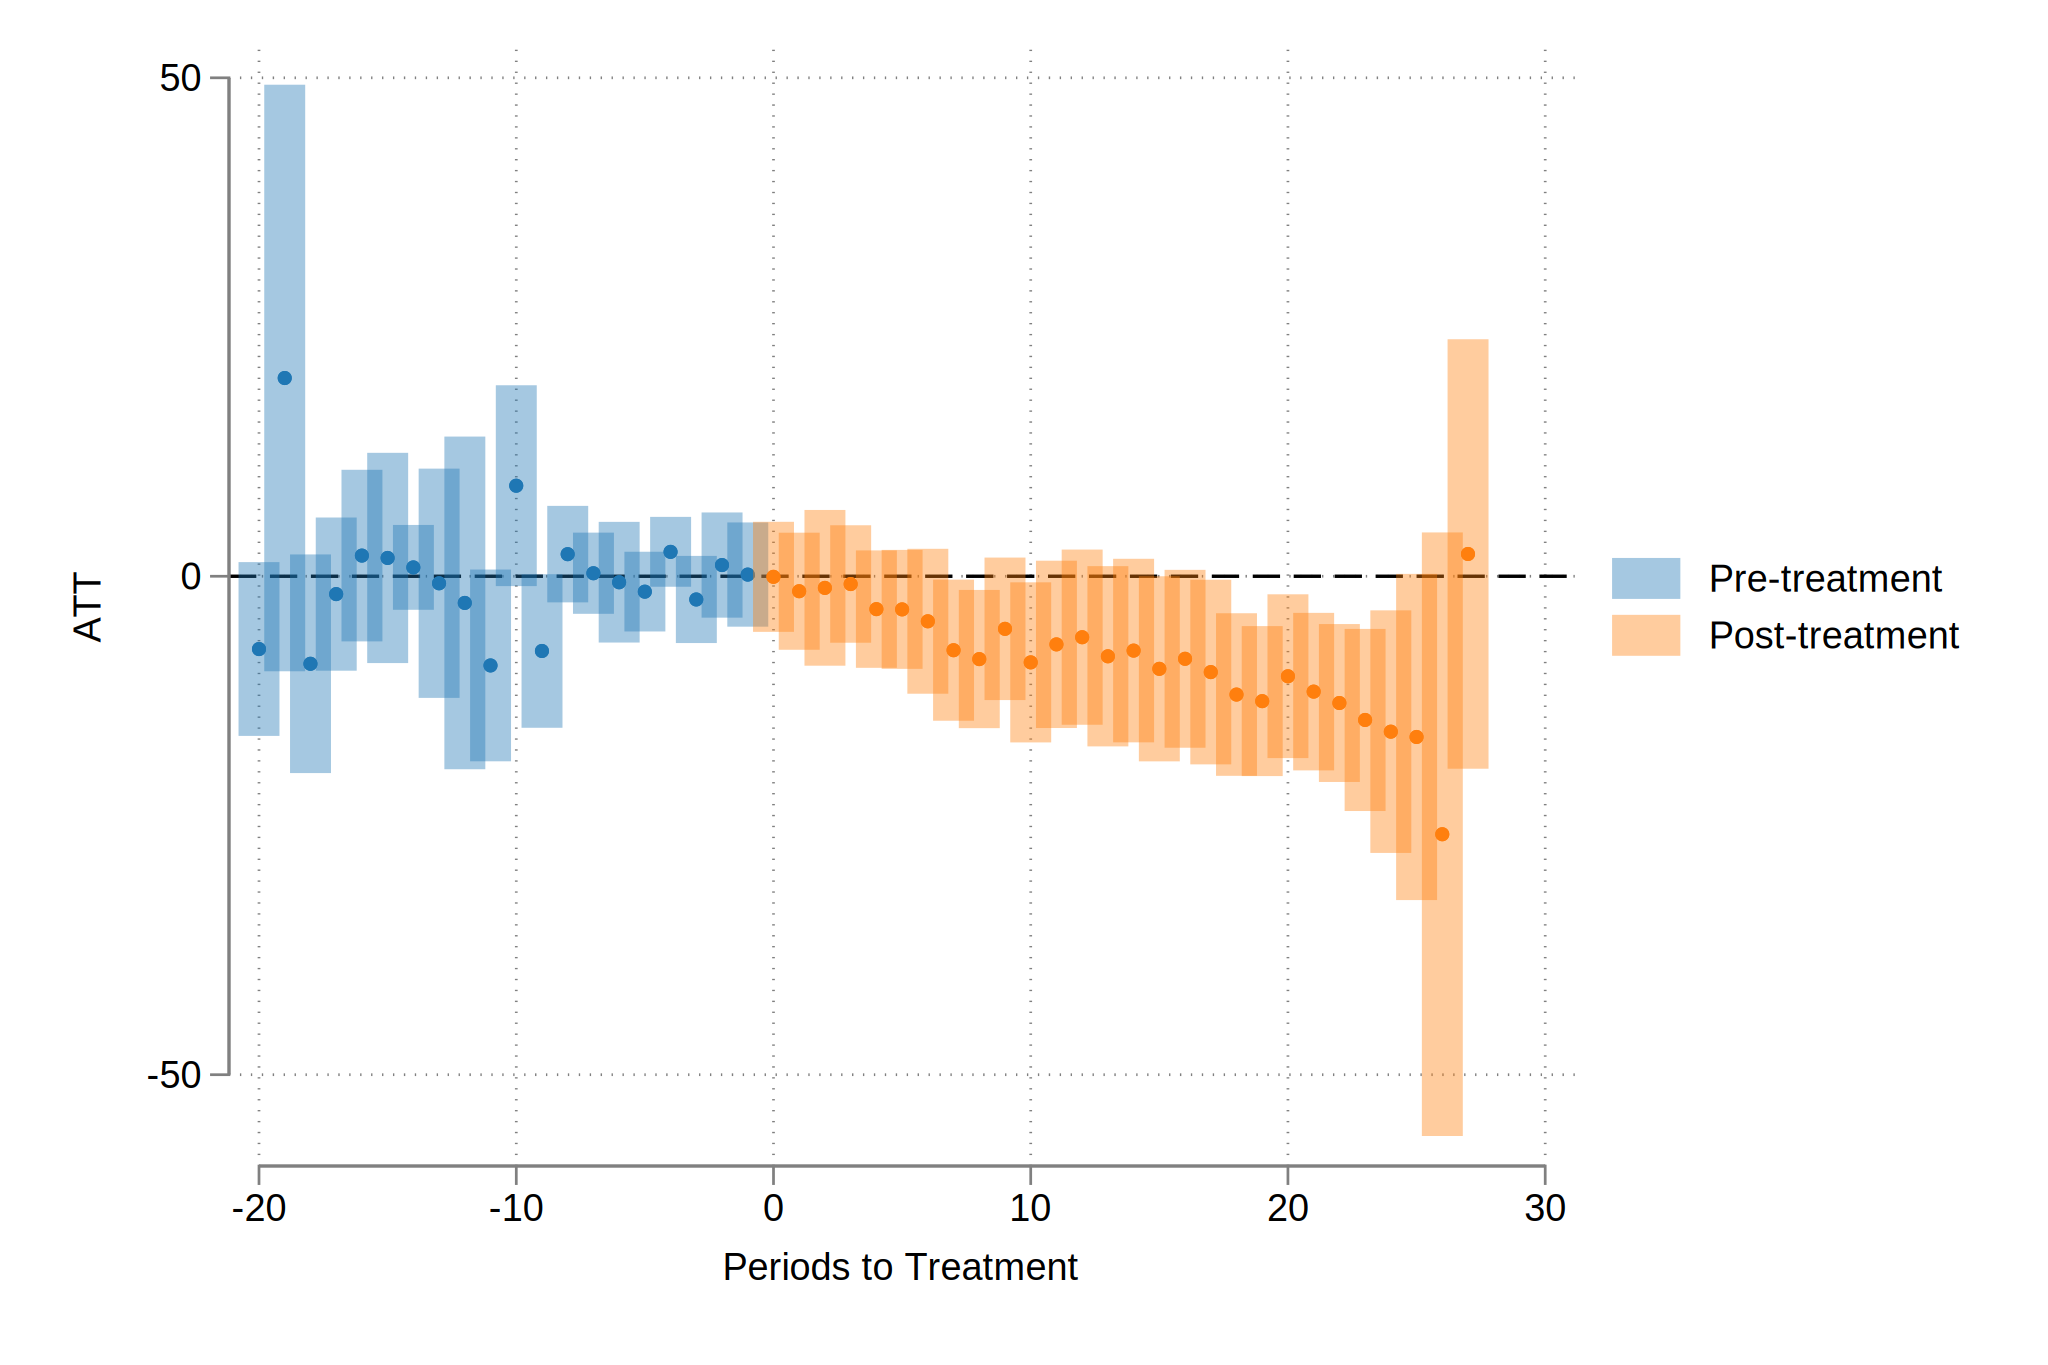

In [39]:
%%stata

//plot the csdid plot
 
csdid_plot

In [ ]:
******************************************
*              Exercise 3                *
******************************************   


. 
. //Use did_imputation to visualize the event study
. 
. // did_imputation gives in similar results
.  did_imputation asmrs stfip  year _nfd , horizons(0/27) pretrend(20) minn(0) 

                                                         Number of obs = 1,617
------------------------------------------------------------------------------
       asmrs | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
        tau0 |   .0245941   1.773557     0.01   0.989    -3.451515    3.500703
        tau1 |  -1.302837   1.862783    -0.70   0.484    -4.953825    2.348151
        tau2 |  -1.482703   2.653062    -0.56   0.576    -6.682609    3.717203
        tau3 |   -.783506   2.590852    -0.30   0.762    -5.861483    4.294471
        tau4 |  -2.925361   2.615227    -1.12   0.263    -8.051112     2.20039
        tau5 |  -2.896338   2.127236    -1.36   0.173    -7.065644    1.272969
        tau6 |   -3.90096

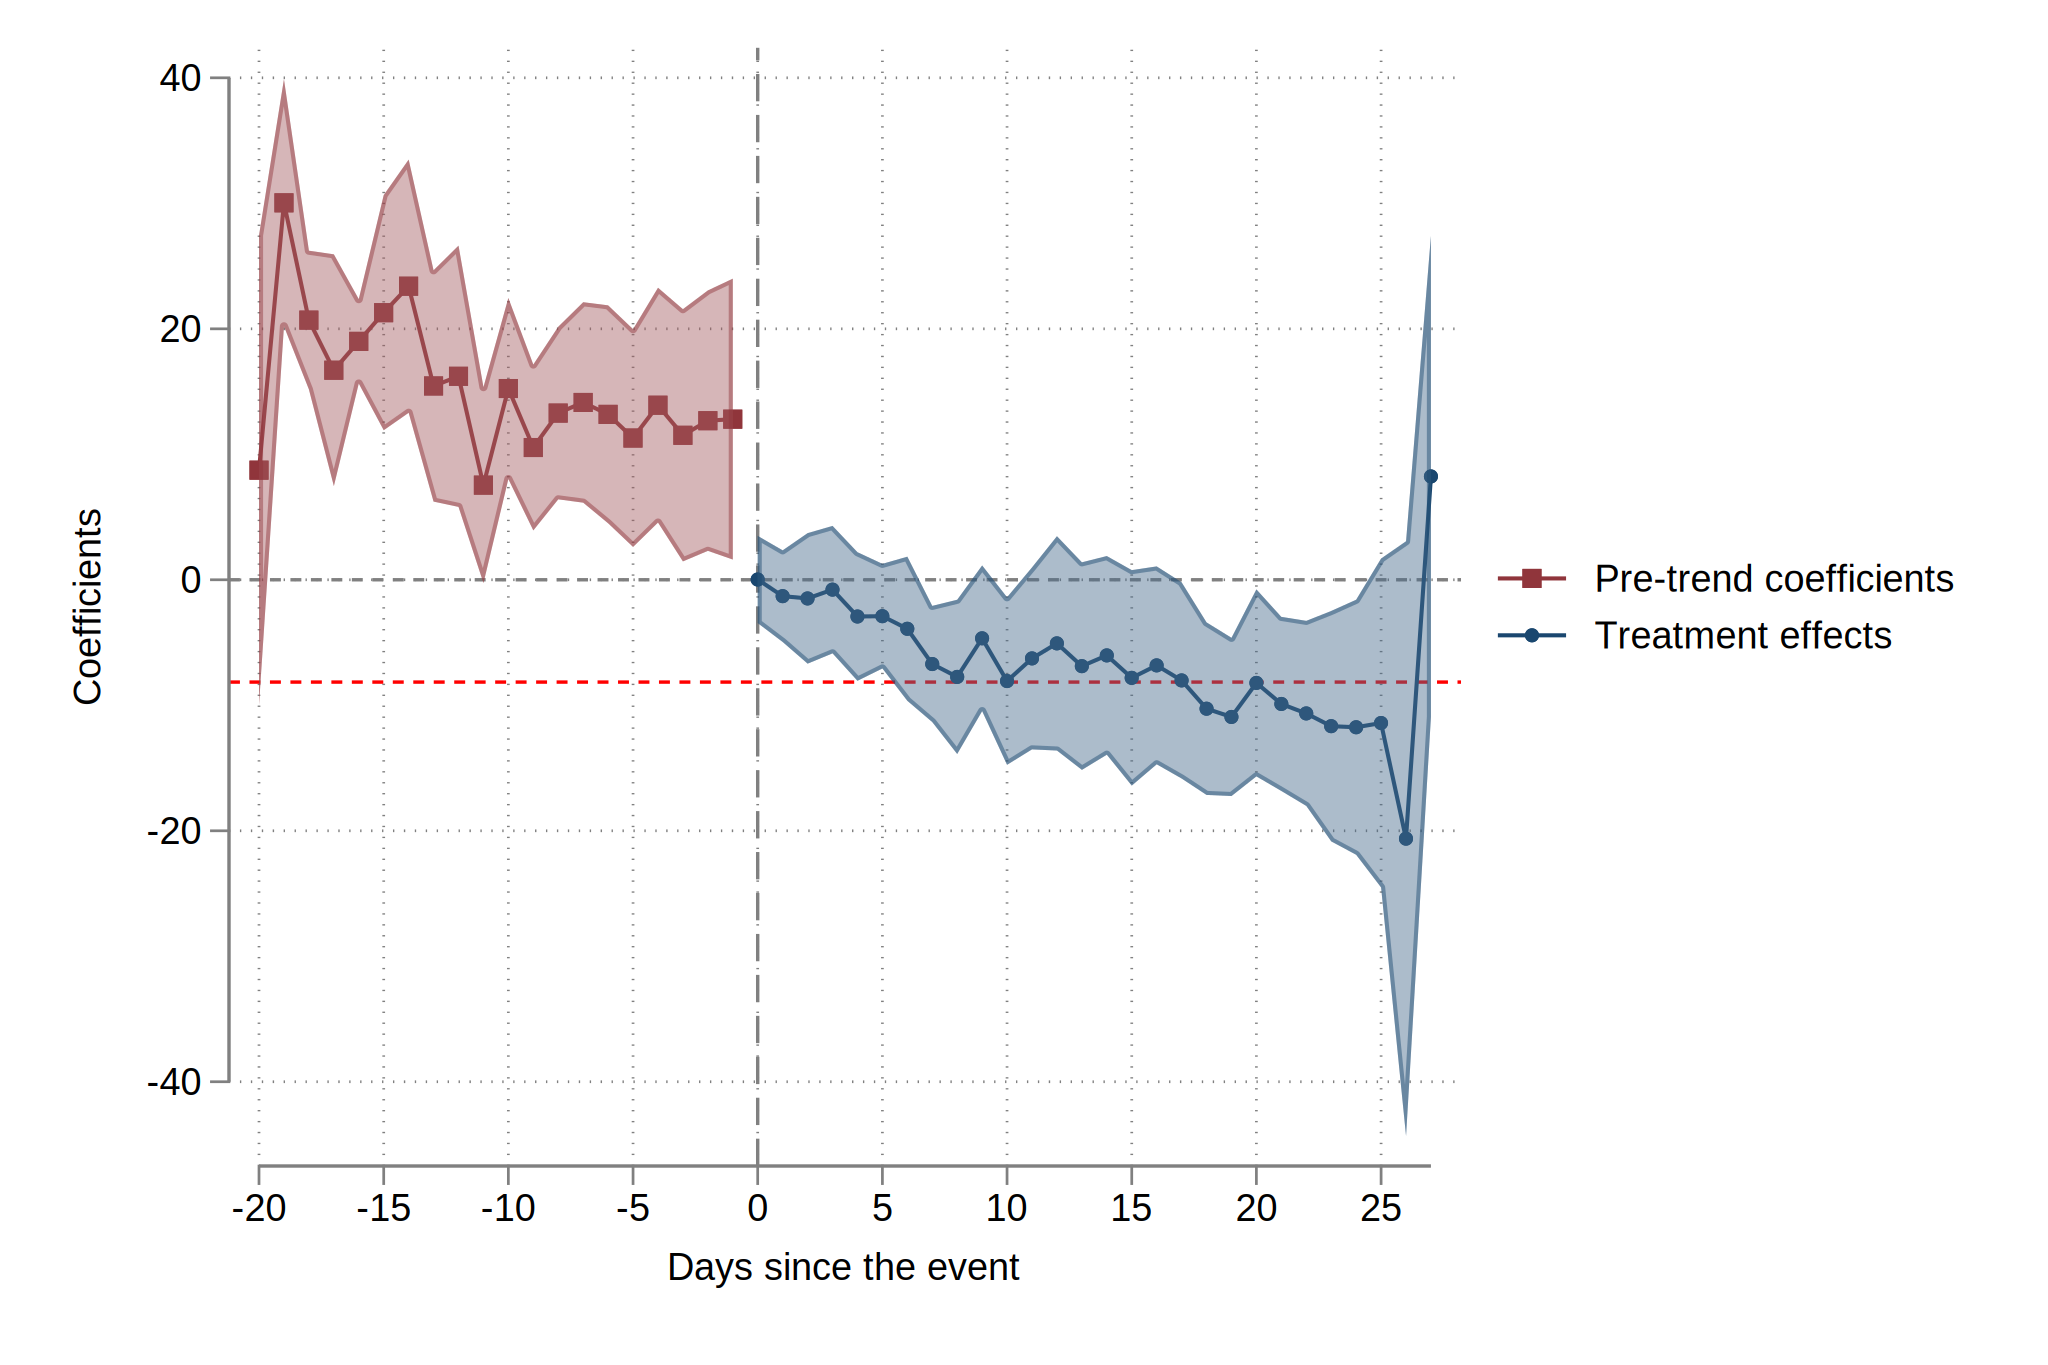

In [40]:
%%stata

//Use did_imputation to visualize the event study

// did_imputation gives in similar results
 did_imputation asmrs stfip  year _nfd , horizons(0/27) pretrend(20) minn(0) 
 estimates store bjs 
 event_plot, default_look graph_opt(xtitle("Days since the event") ///
                                    ytitle("Coefficients") xlabel(-20(5)27) yline(-8.15, lcolor(red))) 
    
    // note here that I added the red horizontal line at y= -8.15 
    //to show where the average results from the csdid fall in this plot
  
  

In [ ]:
%%stata
